In [31]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import seaborn as sns

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="sklearn.decomposition._nmf"
)

matrix_file = "/Users/aleyshachen/BENG_285/proj_3/sbs_96_matrix_our_code.tsv"
# matrix_path = os.path.join("SBS", matrix_file)
matrix_path = matrix_file
assert os.path.exists(matrix_path), f"找不到 {matrix_path}"

# K_list = range(2, 40)
# max_iter = 2000
# random_state = 42

In [32]:
V_df = pd.read_csv(matrix_path, sep="\t", index_col=0)
V_raw = V_df.values.astype(float)
V = V_raw / V_raw.sum(axis=0, keepdims=True)
# V_norm = np.log2(V_raw + 1)
print(V_norm.shape)

(96, 512)


In [33]:
import itertools

# Define hyperparameter options
# K_list = [2, 5, 10]
# pre-select k = 20 from previous elbow plot
K_list = range(2, 40)
init_list = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
solver_list = ['cd', 'mu']
max_iter_list = [200, 500, 1000]
beta_loss_list = ['frobenius', 'kullback-leibler', 'itakura-saito']
random_state = 42

# Store errors and parameters
results = []

# Iterate through all combinations of hyperparameters
for K, init, solver, max_iter, beta_loss in itertools.product(K_list, init_list, solver_list, max_iter_list, beta_loss_list):

    # Skip incompatible combinations
    if solver == 'cd' and beta_loss != 'frobenius':
        continue  # 'cd' only supports 'frobenius'

    try:
        model = NMF(
            n_components=K,
            init=init,
            solver=solver,
            max_iter=max_iter,
            beta_loss=beta_loss,
            random_state=random_state
        )
        W = model.fit_transform(V)
        H = model.components_
        recon = W @ H
        err = np.linalg.norm(V - recon, ord='fro')

        results.append({
            'K': K,
            'init': init,
            'solver': solver,
            'max_iter': max_iter,
            'beta_loss': beta_loss,
            'error': err
        })

        print(f"K={K:2d} init={init:10s} solver={solver:2s} max_iter={max_iter:3d} "
              f"beta_loss={beta_loss:17s} -> Frobenius error = {err:.4f}")

    except Exception as e:
        print(f"Failed for K={K}, init={init}, solver={solver}, max_iter={max_iter}, "
              f"beta_loss={beta_loss} | Error: {e}")

K= 2 init=random     solver=cd max_iter=200 beta_loss=frobenius         -> Frobenius error = 2.6542
K= 2 init=random     solver=cd max_iter=500 beta_loss=frobenius         -> Frobenius error = 2.6542
K= 2 init=random     solver=cd max_iter=1000 beta_loss=frobenius         -> Frobenius error = 2.6542
K= 2 init=random     solver=mu max_iter=200 beta_loss=frobenius         -> Frobenius error = 2.6544
K= 2 init=random     solver=mu max_iter=200 beta_loss=kullback-leibler  -> Frobenius error = 2.7001
Failed for K=2, init=random, solver=mu, max_iter=200, beta_loss=itakura-saito | Error: When beta_loss <= 0 and X contains zeros, the solver may diverge. Please add small values to X, or use a positive beta_loss.
K= 2 init=random     solver=mu max_iter=500 beta_loss=frobenius         -> Frobenius error = 2.6544
K= 2 init=random     solver=mu max_iter=500 beta_loss=kullback-leibler  -> Frobenius error = 2.7001
Failed for K=2, init=random, solver=mu, max_iter=500, beta_loss=itakura-saito | Error: 

In [34]:
df_results = pd.DataFrame(results)

# Sort by error (lowest first)
df_sorted = df_results.sort_values(by='error')
print("Top 5 configurations by lowest reconstruction error:")
print(df_sorted.head())

Top 5 configurations by lowest reconstruction error:
       K      init solver  max_iter  beta_loss     error
1343  39    nndsvd     cd      1000  frobenius  0.949643
1342  39    nndsvd     cd       500  frobenius  0.949645
1361  39  nndsvdar     cd      1000  frobenius  0.949650
1360  39  nndsvdar     cd       500  frobenius  0.949650
1359  39  nndsvdar     cd       200  frobenius  0.950724


In [35]:
for K in df_sorted['K'].unique():
    # get minimum error for each K
    min_error = df_sorted[df_sorted['K'] == K]['error'].min()
    # get the corresponding row
    min_row = df_sorted[(df_sorted['K'] == K) & (df_sorted['error'] == min_error)]
    print(f"K={K} has minimum error {min_error:.4f} with parameters:")
    print(min_row[['init', 'solver', 'max_iter', 'beta_loss']].to_string(index=False))
    # subset = df_sorted[df_sorted['K'] == K]
    # plt.figure(figsize=(12, 6))
    # sns.lineplot(data=subset, x='max_iter', y='error', hue='init', style='solver', markers=True)
    # plt.title(f"Reconstruction Error for K={K}")
    # plt.xlabel("Max Iterations")
    # plt.ylabel("Reconstruction Error")
    # plt.legend(title="Init/Solver")
    # plt.grid()
    # plt.show()

K=39 has minimum error 0.9496 with parameters:
  init solver  max_iter beta_loss
nndsvd     cd      1000 frobenius
K=38 has minimum error 0.9681 with parameters:
  init solver  max_iter beta_loss
nndsvd     cd      1000 frobenius
nndsvd     cd       500 frobenius
K=37 has minimum error 0.9885 with parameters:
  init solver  max_iter beta_loss
random     cd      1000 frobenius
random     cd       500 frobenius
K=36 has minimum error 1.0047 with parameters:
  init solver  max_iter beta_loss
nndsvd     cd       500 frobenius
nndsvd     cd      1000 frobenius
K=35 has minimum error 1.0240 with parameters:
  init solver  max_iter beta_loss
random     cd      1000 frobenius
random     cd       500 frobenius
K=34 has minimum error 1.0437 with parameters:
  init solver  max_iter beta_loss
nndsvd     cd       500 frobenius
nndsvd     cd      1000 frobenius
K=33 has minimum error 1.0630 with parameters:
   init solver  max_iter beta_loss
nndsvda     cd       500 frobenius
nndsvda     cd      100

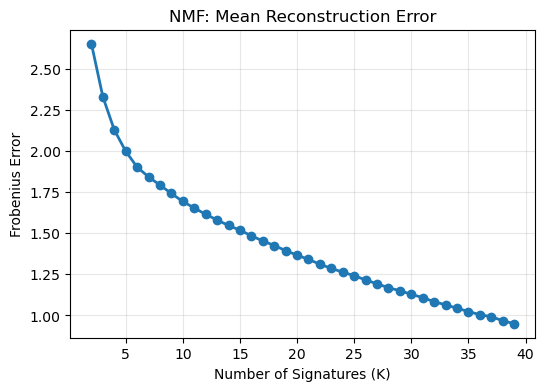

In [40]:
# Elbow plot for errors vs. K
# Optimal hyperparameter selection from previous step
optim_hyperparams = df_sorted.iloc[0]
df_optim_hyperparams = df_sorted[(df_sorted['init'] == optim_hyperparams['init']) &
                                 (df_sorted['solver'] == optim_hyperparams['solver']) &
                                 (df_sorted['max_iter'] == optim_hyperparams['max_iter']) &
                                 (df_sorted['beta_loss'] == optim_hyperparams['beta_loss'])]
K_list = df_optim_hyperparams['K'].unique()
plt.figure(figsize=(6,4))
plt.plot(list(K_list), df_optim_hyperparams['error'], 
             marker="o", linewidth=2)
plt.title("NMF: Mean Reconstruction Error")
plt.xlabel("Number of Signatures (K)")
plt.ylabel("Frobenius Error")
plt.grid(alpha=0.3)
plt.show()

In [42]:
optim_hyperparams

K                   39
init            nndsvd
solver              cd
max_iter          1000
beta_loss    frobenius
error         0.949643
Name: 1343, dtype: object

### Conduct optimal k selection based on bootstrapped NMF, clustering, and silhouette/stability scores

In [ ]:
# Check basis (W) shape
W.shape

(96, 29)

In [ ]:
# Define Gaussian Mixture Model-based normalization from manuscript methods
def gmm_normalize(X):
    """
    GMM-based normalization for mutation data
    
    This function follows a two-step process:
    1. Uses GMM to identify a cutoff value by iteratively separating samples based on 
       their total mutation counts
    2. Normalizes the matrix using the derived cutoff value
       
    Parameters:
    -----------
    X : array-like
        Input data matrix (samples x features/mutations)
        
    Returns:
    --------
    X_norm : array-like
        Normalized data that remains non-negative
    """
    # Step 1: Calculate total mutations per sample (column sums)
    total_mutations = np.sum(X, axis=1)
    
    # Initialize variables for GMM iteration
    all_samples = np.arange(len(total_mutations))
    selected_samples = all_samples.copy()
    converged = False
    
    # Iterative GMM fitting process
    while not converged:
        # Get total mutations for current selection of samples
        current_totals = total_mutations[selected_samples]
        
        # Reshape for GMM
        data_for_gmm = current_totals.reshape(-1, 1)
        
        # Fit GMM with 2 components
        gmm = GaussianMixture(n_components=2, random_state=42)
        labels = gmm.fit_predict(data_for_gmm)
        
        # Get means and standard deviations of the two groups
        group1_indices = np.where(labels == 0)[0]
        group2_indices = np.where(labels == 1)[0]
        
        group1_samples = selected_samples[group1_indices]
        group2_samples = selected_samples[group2_indices]
        
        group1_mean = np.mean(total_mutations[group1_samples])
        group2_mean = np.mean(total_mutations[group2_samples])
        
        # Select the group with larger number of samples
        if len(group1_samples) >= len(group2_samples):
            larger_group = group1_samples
            larger_mean = group1_mean
            smaller_mean = group2_mean
            larger_std = np.std(total_mutations[group1_samples])
        else:
            larger_group = group2_samples
            larger_mean = group2_mean
            smaller_mean = group1_mean
            larger_std = np.std(total_mutations[group2_samples])
        
        # Check convergence criterion: means separated by no more than 4 std
        if abs(larger_mean - smaller_mean) <= 4 * larger_std:
            converged = True
        else:
            # Update selected samples for next iteration
            selected_samples = larger_group
    
    # Calculate cutoff value as average + 2 std of the last large group
    cutoff = np.mean(total_mutations[larger_group]) + 2 * np.std(total_mutations[larger_group])
    
    # Step 2: Normalize the data using the cutoff
    # For each sample, if total mutations > cutoff, scale by cutoff/total
    X_norm = X.copy()
    for i in range(X.shape[0]):
        if total_mutations[i] > cutoff:
            X_norm[i, :] = X[i, :] * (cutoff / total_mutations[i])
    
    # Print information about normalization
    print(f"GMM normalization: Cutoff value = {cutoff:.2f}")
    print(f"GMM normalization: {np.sum(total_mutations > cutoff)} samples scaled down out of {X.shape[0]} total")
    
    return X_norm

In [ ]:
from sklearn.decomposition import NMF
from sklearn.mixture import GaussianMixture
from scipy.optimize import linear_sum_assignment
from scipy.stats import mode
import umap
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.cluster import adjusted_rand_score

# Inputs
# Bootstrap NMF to test stability of basis (W)
K_list = range(1, 26) 
n_bootstraps = 100
normalization_method = "gmm" 

def poisson_resample(X):
    """Poisson resampling for count-like data"""
    return np.random.poisson(X)

def normalize_data(X, method="minmax"):
    """
    Normalize data ensuring non-negative values for NMF
    
    Parameters:
    -----------
    X : array-like
        Input data matrix
    method : str
        Normalization method:
        - "log2": Log2 transform (adds 1 to avoid log(0))
        - "minmax": MinMax scaling to [0,1] range
        - "gmm": Gaussian Mixture Model-based normalization
        - "none": No normalization
    
    Returns:
    --------
    X_norm : array-like
        Normalized data
    """
    if method == "log2":
        return np.log2(X + 1)
    elif method == "gmm":
        # GMM-based normalization as described
        return gmm_normalize(X)
    elif method == "none":
        return X.copy()
    else:
        raise ValueError(f"Unsupported normalization method: {method}")

# Align clusters using Hungarian algorithm
def align_clusters(ref_labels, pred_labels, K):
    # Create confusion matrix
    cost_matrix = np.zeros((K, K))
    unique_ref = np.unique(ref_labels)
    unique_pred = np.unique(pred_labels)
    
    for i, ref_label in enumerate(unique_ref):
        for j, pred_label in enumerate(unique_pred):
            cost_matrix[i, j] = -np.sum((ref_labels == ref_label) & (pred_labels == pred_label))
    
    # Pad if necessary
    if cost_matrix.shape[0] < K or cost_matrix.shape[1] < K:
        padded = np.zeros((K, K))
        padded[:cost_matrix.shape[0], :cost_matrix.shape[1]] = cost_matrix
        cost_matrix = padded
    
    # Solve assignment problem
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create mapping dictionary
    mapping = {}
    for i, j in zip(row_ind, col_ind):
        if i < len(unique_ref) and j < len(unique_pred):
            mapping[unique_pred[j]] = unique_ref[i]
    
    # Apply mapping
    aligned_labels = np.array([mapping.get(label, -1) for label in pred_labels])
    return aligned_labels

def calculate_stability_score(aligned_assignments):
    """
    Calculate stability score from aligned assignments across bootstraps
    using average pairwise Adjusted Rand Index
    """
    n_bootstraps = aligned_assignments.shape[0]
    ari_scores = []
    
    for i in range(n_bootstraps):
        for j in range(i+1, n_bootstraps):
            # Skip comparisons with -1 values (unassigned)
            mask_i = aligned_assignments[i] != -1
            mask_j = aligned_assignments[j] != -1
            mask = mask_i & mask_j
            
            if np.sum(mask) < 2:  # Need at least 2 samples to compare
                continue
                
            ari = adjusted_rand_score(
                aligned_assignments[i][mask],
                aligned_assignments[j][mask]
            )
            ari_scores.append(ari)
    
    return np.mean(ari_scores) if ari_scores else 0.0

def analyze_nmf_stability(V_raw, K_list, n_bootstraps=100, 
                         normalization_method="minmax"):
    """
    Analyze NMF stability using bootstrapping
    
    V_raw : array-like
        Input data matrix (samples x features)
    K_list : list or range
        List of K values to test
    n_bootstraps : int
        Number of bootstrap samples
    normalization_method : str
        Method for data normalization ('log2', 'minmax', 'gmm', 'none')
        
    results : list
        List of dictionaries containing results for each K
    """
    optim_hyperparams = {
        'init': 'nndsvd',
        'solver': 'cd',  # Coordinate descent
        'beta_loss': 'frobenius',
        'max_iter': 1000,
        'tol': 1e-4,
        'alpha': 0.0,  # Add some regularization (can be tuned)
        'l1_ratio': 0.0  # Ratio of L1 vs L2 regularization
    }
    
    results = []
    
    # First normalize the raw data once for plotting and reference
    V_norm_ref = normalize_data(V_raw, method=normalization_method)
    
    for K in K_list:
        print(f"Running K={K}")
        silhouette_scores = []
        factorization_errors = []
        stability_scores_list = []
        cluster_assignments = np.full((n_bootstraps, V_raw.shape[0]), -1)
        feature_contributions = []  # Store H matrices
        
        for b in range(n_bootstraps):
            # Resample data using Poisson
            V_boot = poisson_resample(V_raw)
            
            # Normalize bootstrapped data
            V_boot_norm = normalize_data(V_boot, method=normalization_method)
            
            # Apply NMF with optimized hyperparameters
            model = NMF(n_components=K, 
                       init=optim_hyperparams['init'], 
                       solver=optim_hyperparams['solver'],
                       beta_loss=optim_hyperparams['beta_loss'], 
                       max_iter=optim_hyperparams['max_iter'],
                       random_state=100 + b)
            
            try:
                W = model.fit_transform(V_boot_norm)
                H = model.components_
                
                # Store feature contributions
                feature_contributions.append(H)
                
                # Get cluster assignments (hard clustering based on max coefficient)
                labels = np.argmax(W, axis=1)
                cluster_assignments[b] = labels
                
                # Calculate silhouette score in the W space (NMF embedding space)
                W_distances = pairwise_distances(W)
                try:
                    score = silhouette_score(W_distances, labels, metric="precomputed")
                except:
                    score = np.nan
                silhouette_scores.append(score)
                
                # Store reconstruction error
                factorization_errors.append(model.reconstruction_err_)
                
            except Exception as e:
                print(f"Error in bootstrap {b} for K={K}: {e}")
                # If error, skip this bootstrap
                continue
                
        # If too many bootstraps failed, skip this K value
        if np.isnan(np.nanmean(silhouette_scores)):
            print(f"Skipping K={K} due to insufficient valid bootstraps")
            continue
            
        # Align all bootstraps to first bootstrap
        valid_bootstraps = ~np.all(cluster_assignments == -1, axis=1)
        if np.sum(valid_bootstraps) < 2:
            print(f"Skipping K={K} due to insufficient valid bootstraps")
            continue
            
        # Use the first valid bootstrap as reference
        ref_idx = np.where(valid_bootstraps)[0][0]
        ref = cluster_assignments[ref_idx]
        
        aligned_assignments = np.array([
            align_clusters(ref, cluster_assignments[i], K) if valid_bootstraps[i] else np.full(V_raw.shape[0], -1)
            for i in range(n_bootstraps)
        ])
        
        # Calculate stability score
        stability_score = calculate_stability_score(aligned_assignments)
        
        # Compute co-occurrence matrix
        co_matrix = np.zeros((V_raw.shape[0], V_raw.shape[0]))
        counts = np.zeros((V_raw.shape[0], V_raw.shape[0]))
        
        for i in range(n_bootstraps):
            if not valid_bootstraps[i]:
                continue
                
            for c in range(K):
                members = np.where(aligned_assignments[i] == c)[0]
                if len(members) > 1:
                    co_matrix[np.ix_(members, members)] += 1
                    counts[np.ix_(members, members)] += 1
        
        # Normalize co-occurrence matrix
        with np.errstate(divide='ignore', invalid='ignore'):
            co_matrix = np.divide(co_matrix, counts)
            co_matrix[np.isnan(co_matrix)] = 0
            
        # Get majority cluster assignment
        majority_cluster = mode(aligned_assignments, axis=0, keepdims=False).mode
        
        # Create UMAP embedding of original data
        embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(V_norm_ref)
        
        # Average the feature contributions (H matrices)
        if feature_contributions:
            avg_H = np.mean([H for H in feature_contributions], axis=0)
        else:
            avg_H = np.zeros((K, V_raw.shape[1]))
        
        # Store all results
        results.append({
            "K": K,
            "silhouette_scores": silhouette_scores,
            "mean_silhouette": np.nanmean(silhouette_scores),
            "std_silhouette": np.nanstd(silhouette_scores),
            "stability_score": stability_score,
            "factorization_errors": factorization_errors,
            "mean_error": np.mean(factorization_errors) if factorization_errors else np.nan,
            "co_matrix": co_matrix,
            "umap_embedding": embedding,
            "majority_cluster": majority_cluster,
            "feature_contributions": avg_H
        })
        
        # --- Visualizations ---
        visualize_nmf_results(K, co_matrix, embedding, majority_cluster, silhouette_scores, avg_H, factorization_errors)
    
    # Plot summary results
    plot_stability_summary(results)
    
    return results

def visualize_nmf_results(K, co_matrix, embedding, majority_cluster, silhouette_scores, feature_contributions, factorization_errors):
    """Create visualizations for a specific K value"""
    # Create figure with subplots
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 3)
    
    # 1. Co-occurrence matrix
    ax1 = fig.add_subplot(gs[0, 0])
    im = ax1.imshow(co_matrix, cmap="viridis")
    ax1.set_title(f"Co-occurrence Matrix (K={K})")
    plt.colorbar(im, ax=ax1)
    
    # 2. UMAP plot with clusters
    ax2 = fig.add_subplot(gs[0, 1])
    scatter = ax2.scatter(embedding[:, 0], embedding[:, 1], c=majority_cluster, cmap="tab10", s=20, alpha=0.7)
    ax2.set_title(f"UMAP with Consensus Clusters (K={K})")
    
    # Add legend if not too many clusters
    if K <= 10:
        legend1 = ax2.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
        ax2.add_artist(legend1)
    
    # 3. Silhouette score distribution
    ax3 = fig.add_subplot(gs[0, 2])
    sns.histplot(silhouette_scores, kde=True, bins=10, ax=ax3)
    ax3.axvline(np.nanmean(silhouette_scores), color='r', linestyle='dashed', 
               linewidth=1, label=f'Mean: {np.nanmean(silhouette_scores):.3f}')
    ax3.set_title(f"Silhouette Score Distribution (K={K})")
    ax3.set_xlabel("Silhouette Score")
    ax3.set_ylabel("Frequency")
    ax3.legend()
    
    # 4. Feature contributions heatmap (normalized)
    ax4 = fig.add_subplot(gs[1, :2])
    if feature_contributions.shape[1] > 20:
        # If too many features, show only top contributors per component
        top_n = 20
        # Get indices of top contributors for each component
        top_indices = np.argsort(-feature_contributions, axis=1)[:, :top_n]
        
        # Create a new matrix with only top contributors
        top_H = np.zeros((K, top_n))
        for i in range(K):
            top_H[i] = feature_contributions[i, top_indices[i]]
        
        # Plot heatmap of top contributors
        sns.heatmap(top_H, cmap="viridis", ax=ax4)
        ax4.set_title(f"Top {top_n} Feature Contributions per Component (K={K})")
        ax4.set_xlabel(f"Top {top_n} Features (different for each component)")
        ax4.set_ylabel("Components")
    else:
        # If few features, show all
        sns.heatmap(feature_contributions, cmap="viridis", ax=ax4)
        ax4.set_title(f"Feature Contributions (K={K})")
        ax4.set_xlabel("Features")
        ax4.set_ylabel("Components")
    
    # 5. Factorization error distribution
    ax5 = fig.add_subplot(gs[1, 2])
    sns.histplot(factorization_errors, kde=True, bins=10, ax=ax5)
    ax5.axvline(np.mean(factorization_errors), color='r', linestyle='dashed', 
               linewidth=1, label=f'Mean: {np.mean(factorization_errors):.3f}')
    ax5.set_title(f"Factorization Error Distribution (K={K})")
    ax5.set_xlabel("Reconstruction Error")
    ax5.set_ylabel("Frequency")
    ax5.legend()
    
    plt.tight_layout()
    plt.show()

def plot_stability_summary(results):
    """Plot summary metrics across all K values"""
    # Extract relevant data
    K_values = [res["K"] for res in results]
    silhouette_means = [res["mean_silhouette"] for res in results]
    silhouette_stds = [res["std_silhouette"] for res in results]
    stability_scores = [res["stability_score"] for res in results]
    factorization_errors = [res["mean_error"] for res in results]
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Silhouette scores
    ax1.errorbar(K_values, silhouette_means, yerr=silhouette_stds, fmt='o-', capsize=5)
    ax1.set_title("Mean Silhouette Score vs. K")
    ax1.set_xlabel("Number of Components (K)")
    ax1.set_ylabel("Silhouette Score")
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Stability scores
    ax2.plot(K_values, stability_scores, 'o-', color='green')
    ax2.set_title("Cluster Stability vs. K")
    ax2.set_xlabel("Number of Components (K)")
    ax2.set_ylabel("Stability Score (ARI)")
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # 3. Factorization errors
    ax3.plot(K_values, factorization_errors, 'o-', color='red')
    ax3.set_title("Factorization Error vs. K")
    ax3.set_xlabel("Number of Components (K)")
    ax3.set_ylabel("Mean Reconstruction Error")
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Create and plot combined metric for selecting optimal K
    # Normalize metrics to [0,1] range
    norm_silhouette = (silhouette_means - np.min(silhouette_means)) / (np.max(silhouette_means) - np.min(silhouette_means) + 1e-10)
    norm_stability = (stability_scores - np.min(stability_scores)) / (np.max(stability_scores) - np.min(stability_scores) + 1e-10)
    
    # Invert errors (lower is better)
    norm_error = 1 - (factorization_errors - np.min(factorization_errors)) / (np.max(factorization_errors) - np.min(factorization_errors) + 1e-10)
    
    # Combine metrics (equal weights)
    combined_score = (norm_silhouette + norm_stability + norm_error) / 3
    
    # Plot combined score
    plt.figure(figsize=(8, 6))
    plt.plot(K_values, combined_score, 'o-', color='purple')
    plt.title("Combined Score for Optimal K Selection")
    plt.xlabel("Number of Components (K)")
    plt.ylabel("Combined Score")
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Mark optimal K
    best_k_idx = np.argmax(combined_score)
    best_k = K_values[best_k_idx]
    plt.axvline(best_k, color='r', linestyle='--', alpha=0.7)
    plt.text(best_k + 0.5, np.max(combined_score) - 0.1, f"Optimal K = {best_k}", 
             color='red', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Recommended optimal number of components (K): {best_k}")
    print(f"- Silhouette score: {silhouette_means[best_k_idx]:.4f}")
    print(f"- Stability score: {stability_scores[best_k_idx]:.4f}")
    print(f"- Factorization error: {factorization_errors[best_k_idx]:.4f}")
    
    return best_k

GMM normalization: Cutoff value = 923.33
GMM normalization: 57 samples scaled down out of 96 total
Running K=1
GMM normalization: Cutoff value = 908.71
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 935.95
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 986.29
GMM normalization: 53 samples scaled down out of 96 total
GMM normalization: Cutoff value = 914.33
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 949.99
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 946.77
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 930.82
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1030.19
GMM normalization: 50 samples scaled down out of 96 total
GMM normalization: Cutoff value = 929.11
GMM normalization: 56 samples scaled down out of 96 tot

/var/folders/1c/p3sgf2gd2r50t_csxf8vrdv80000gn/T/ipykernel_61673/3187142120.py:201: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(silhouette_scores)):


Skipping K=1 due to insufficient valid bootstraps
Running K=2
GMM normalization: Cutoff value = 907.87
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 878.91
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 964.97
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 942.88
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 940.67
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 915.75
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 956.28
GMM normalization: 54 samples scaled down out of 96 total
GMM normalization: Cutoff value = 938.24
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 912.18
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 949.95
GMM no

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


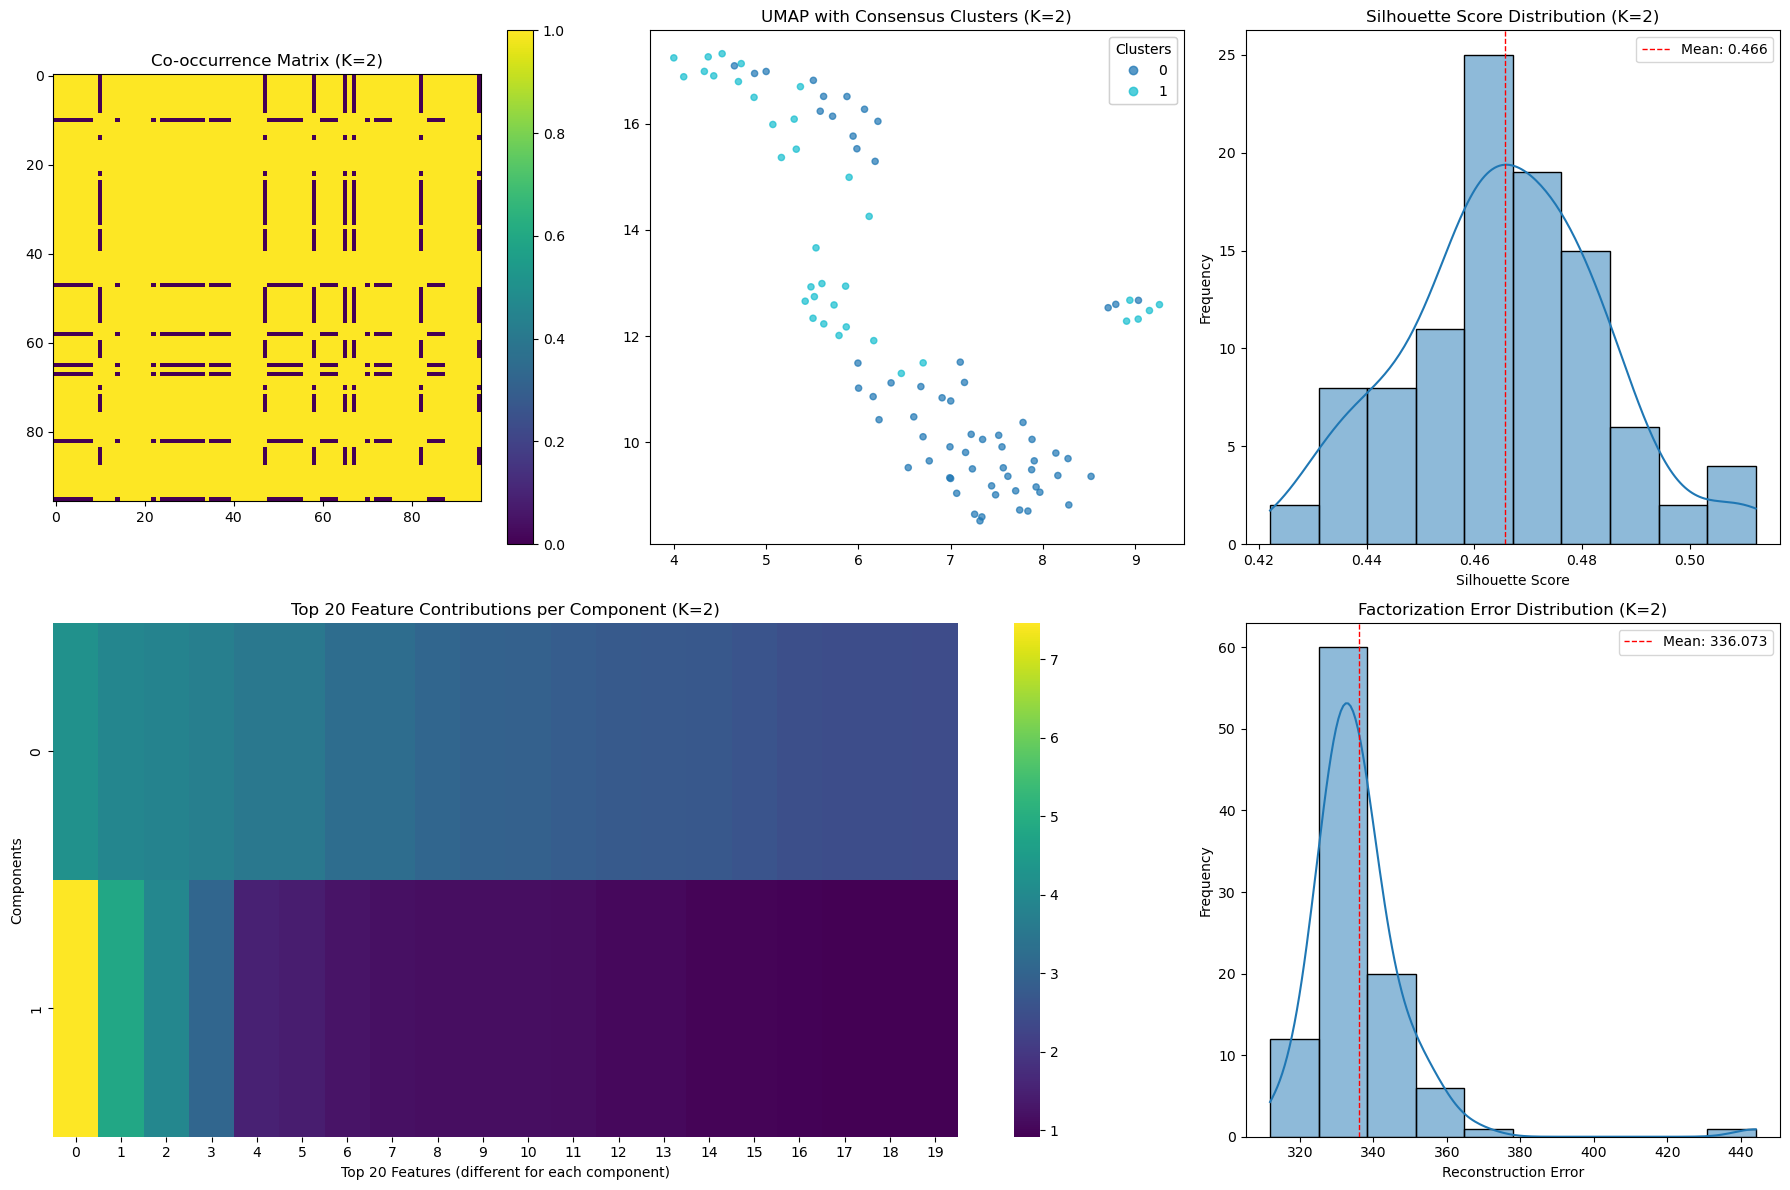

Running K=3
GMM normalization: Cutoff value = 930.79
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 877.62
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 968.73
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 897.64
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 950.64
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 903.30
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 908.12
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 904.26
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 902.33
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 924.11
GMM normalization: 58 samples scaled down out of 96 tota

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


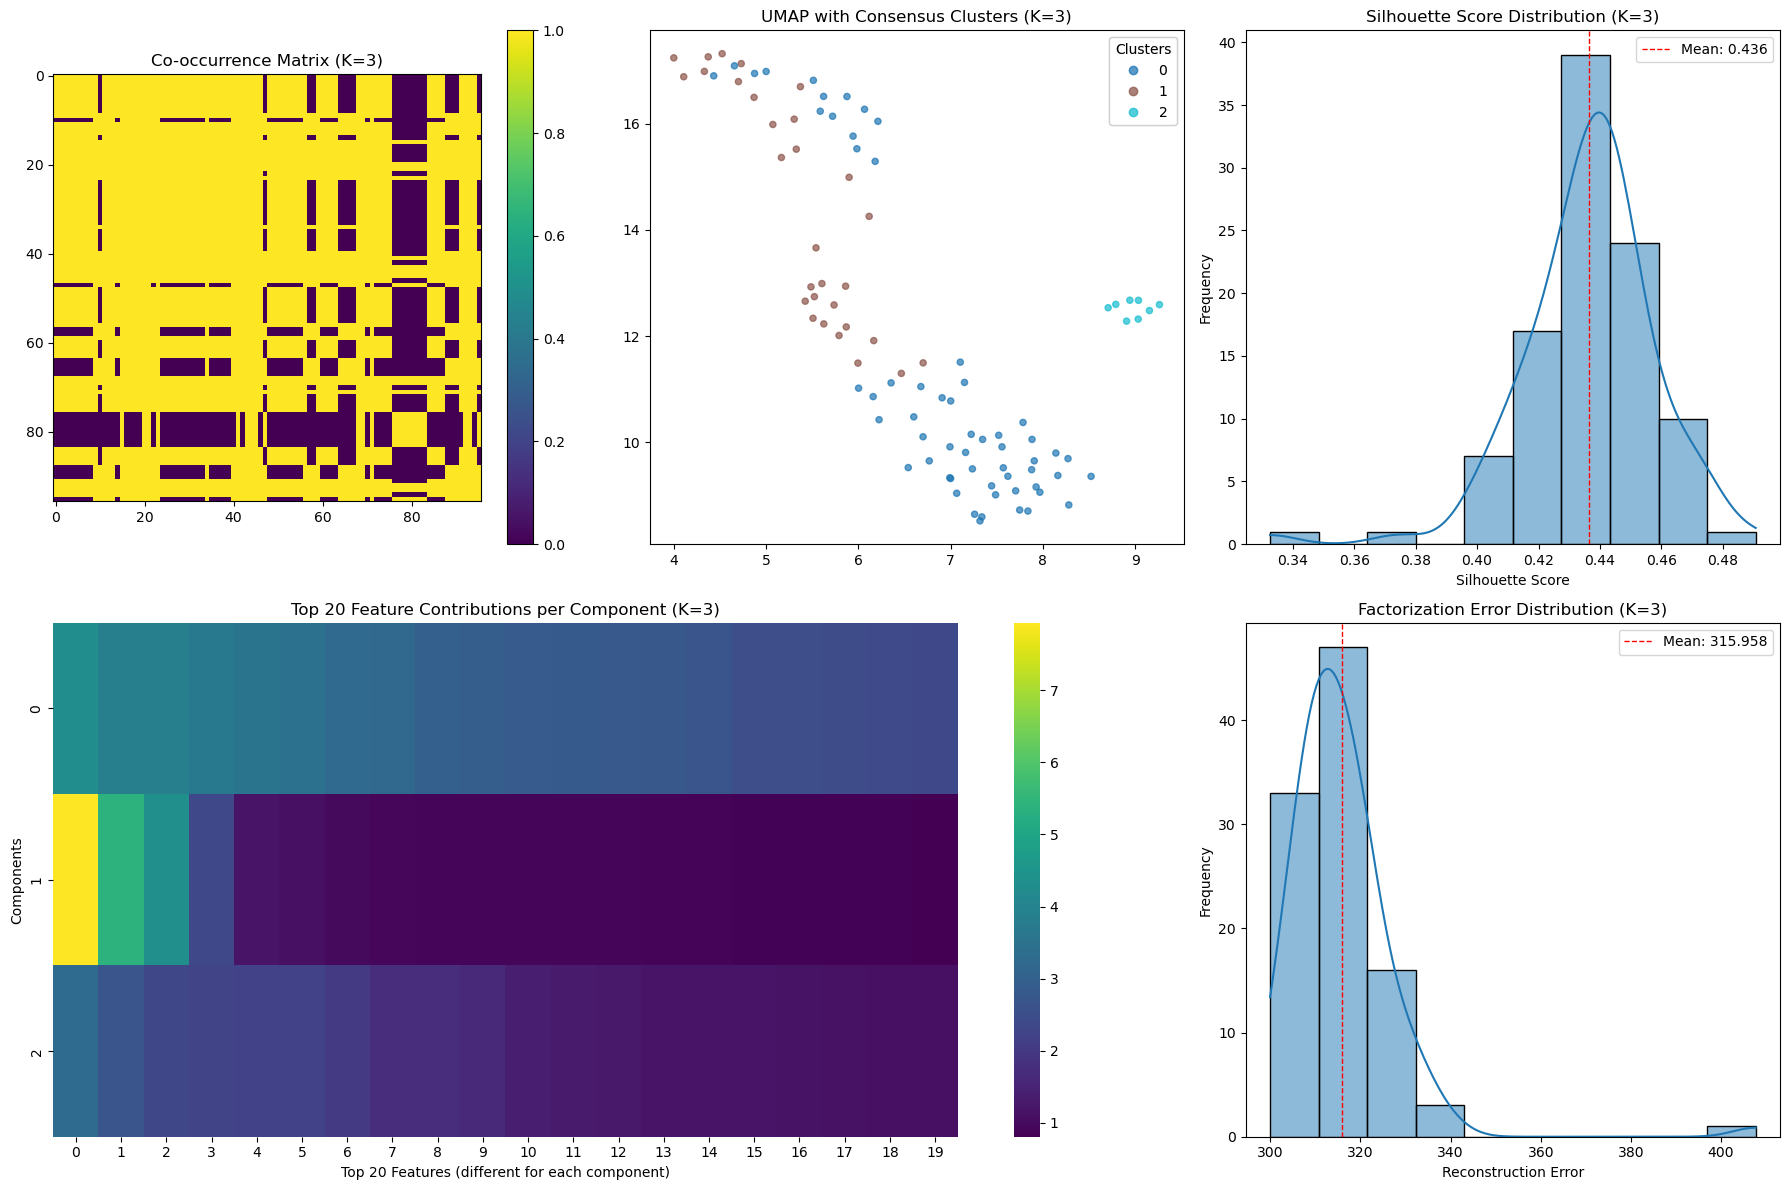

Running K=4
GMM normalization: Cutoff value = 931.56
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 950.57
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1082.73
GMM normalization: 50 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1028.37
GMM normalization: 52 samples scaled down out of 96 total
GMM normalization: Cutoff value = 965.29
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 870.30
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 918.97
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 922.61
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 993.14
GMM normalization: 53 samples scaled down out of 96 total
GMM normalization: Cutoff value = 920.68
GMM normalization: 58 samples scaled down out of 96 to

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


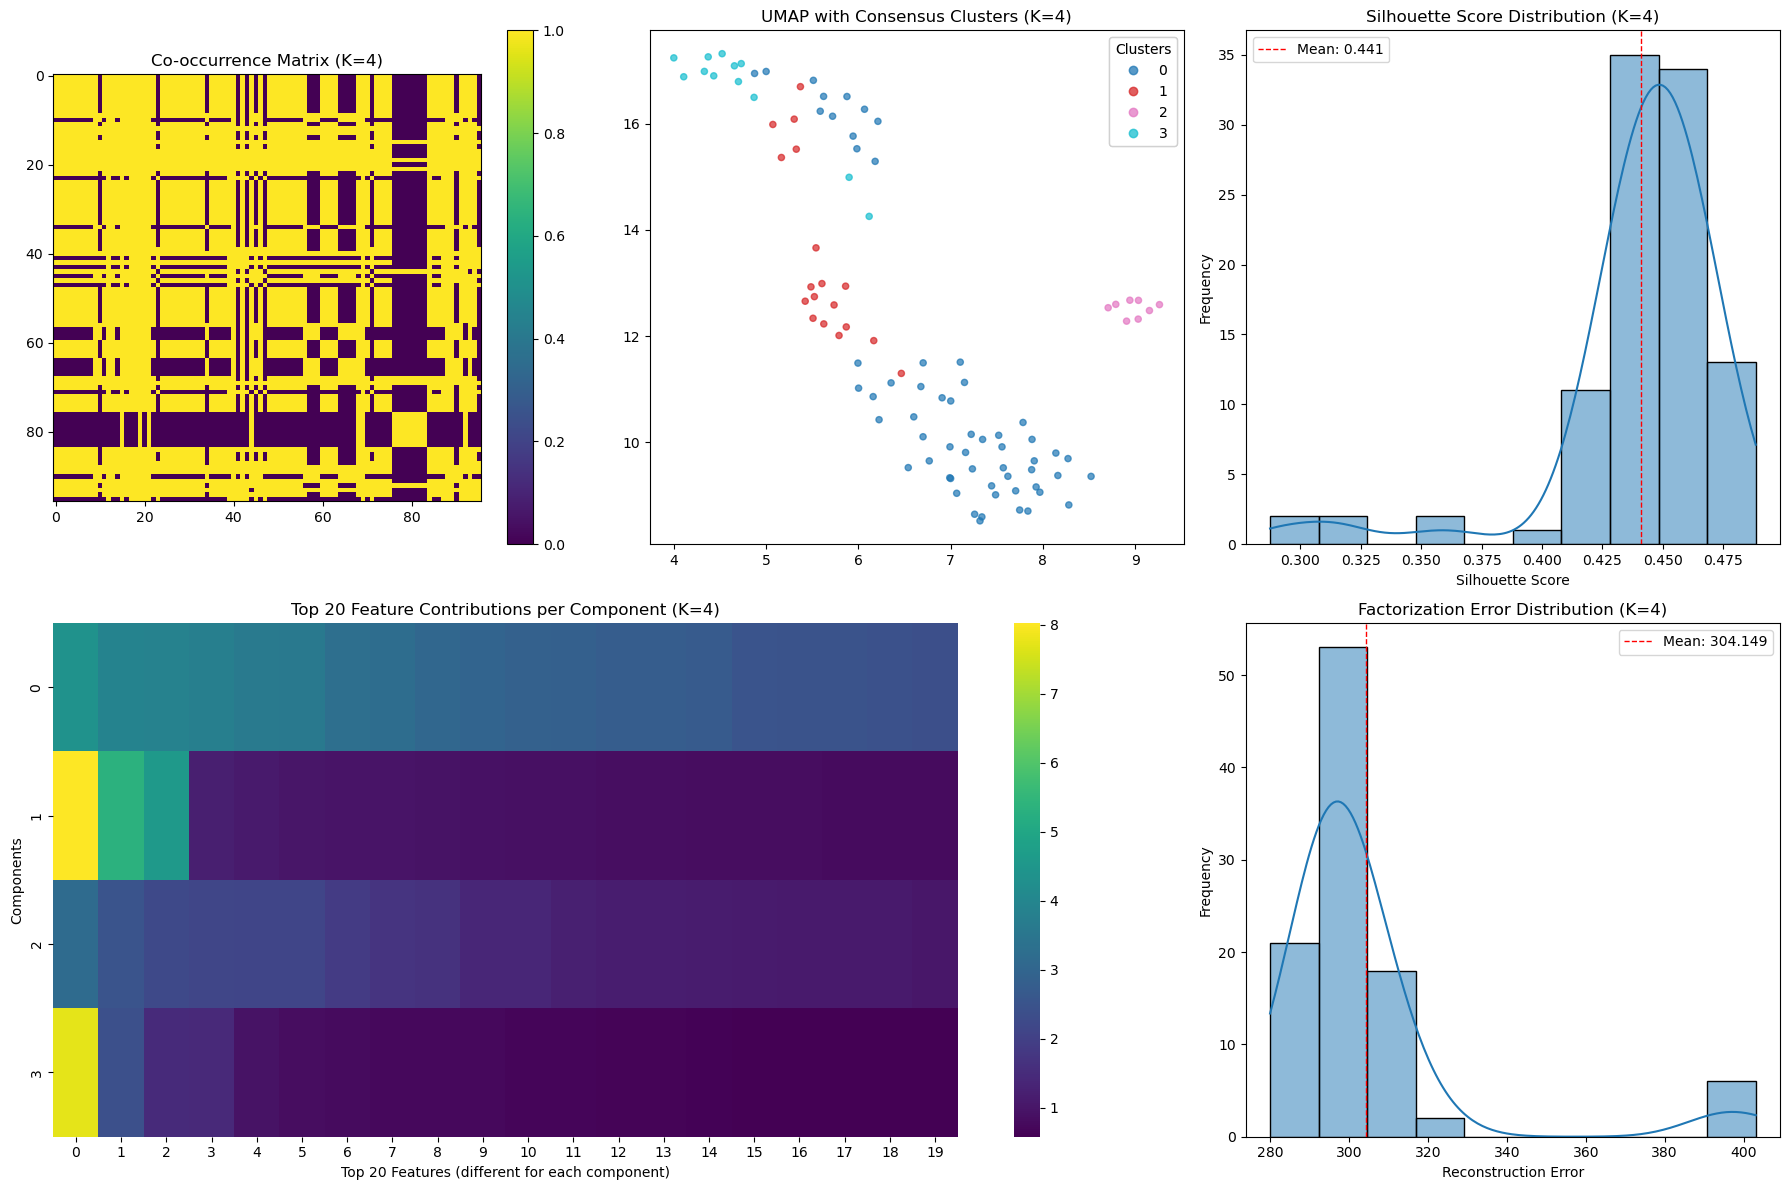

Running K=5
GMM normalization: Cutoff value = 965.92
GMM normalization: 52 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1009.34
GMM normalization: 53 samples scaled down out of 96 total
GMM normalization: Cutoff value = 885.07
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 933.41
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 900.90
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 902.98
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 929.57
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1588.99
GMM normalization: 36 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1020.21
GMM normalization: 52 samples scaled down out of 96 total
GMM normalization: Cutoff value = 982.51
GMM normalization: 54 samples scaled down out of 96 t

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


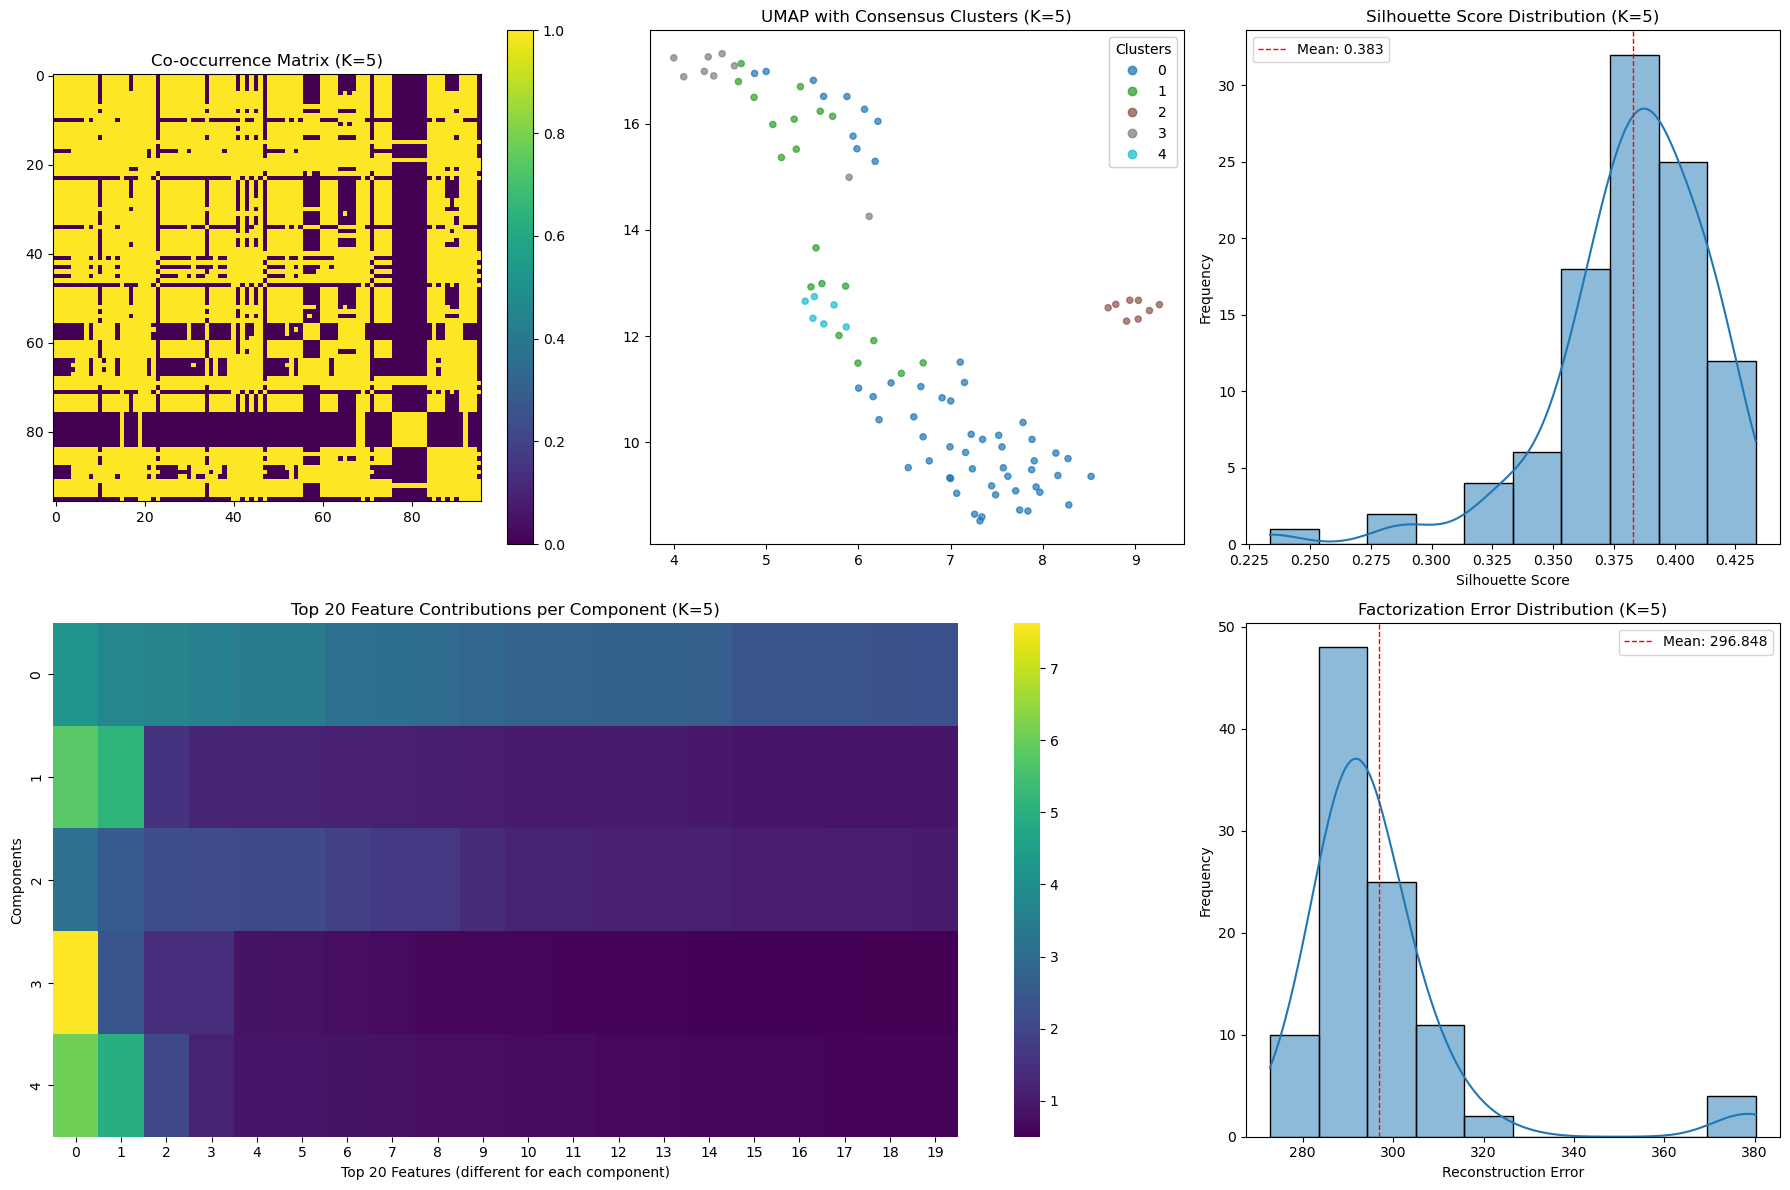

Running K=6
GMM normalization: Cutoff value = 978.89
GMM normalization: 52 samples scaled down out of 96 total
GMM normalization: Cutoff value = 888.66
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 942.24
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 908.90
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 890.35
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 917.41
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 905.02
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 943.16
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 969.35
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 958.39
GMM normalization: 55 samples scaled down out of 96 tota

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


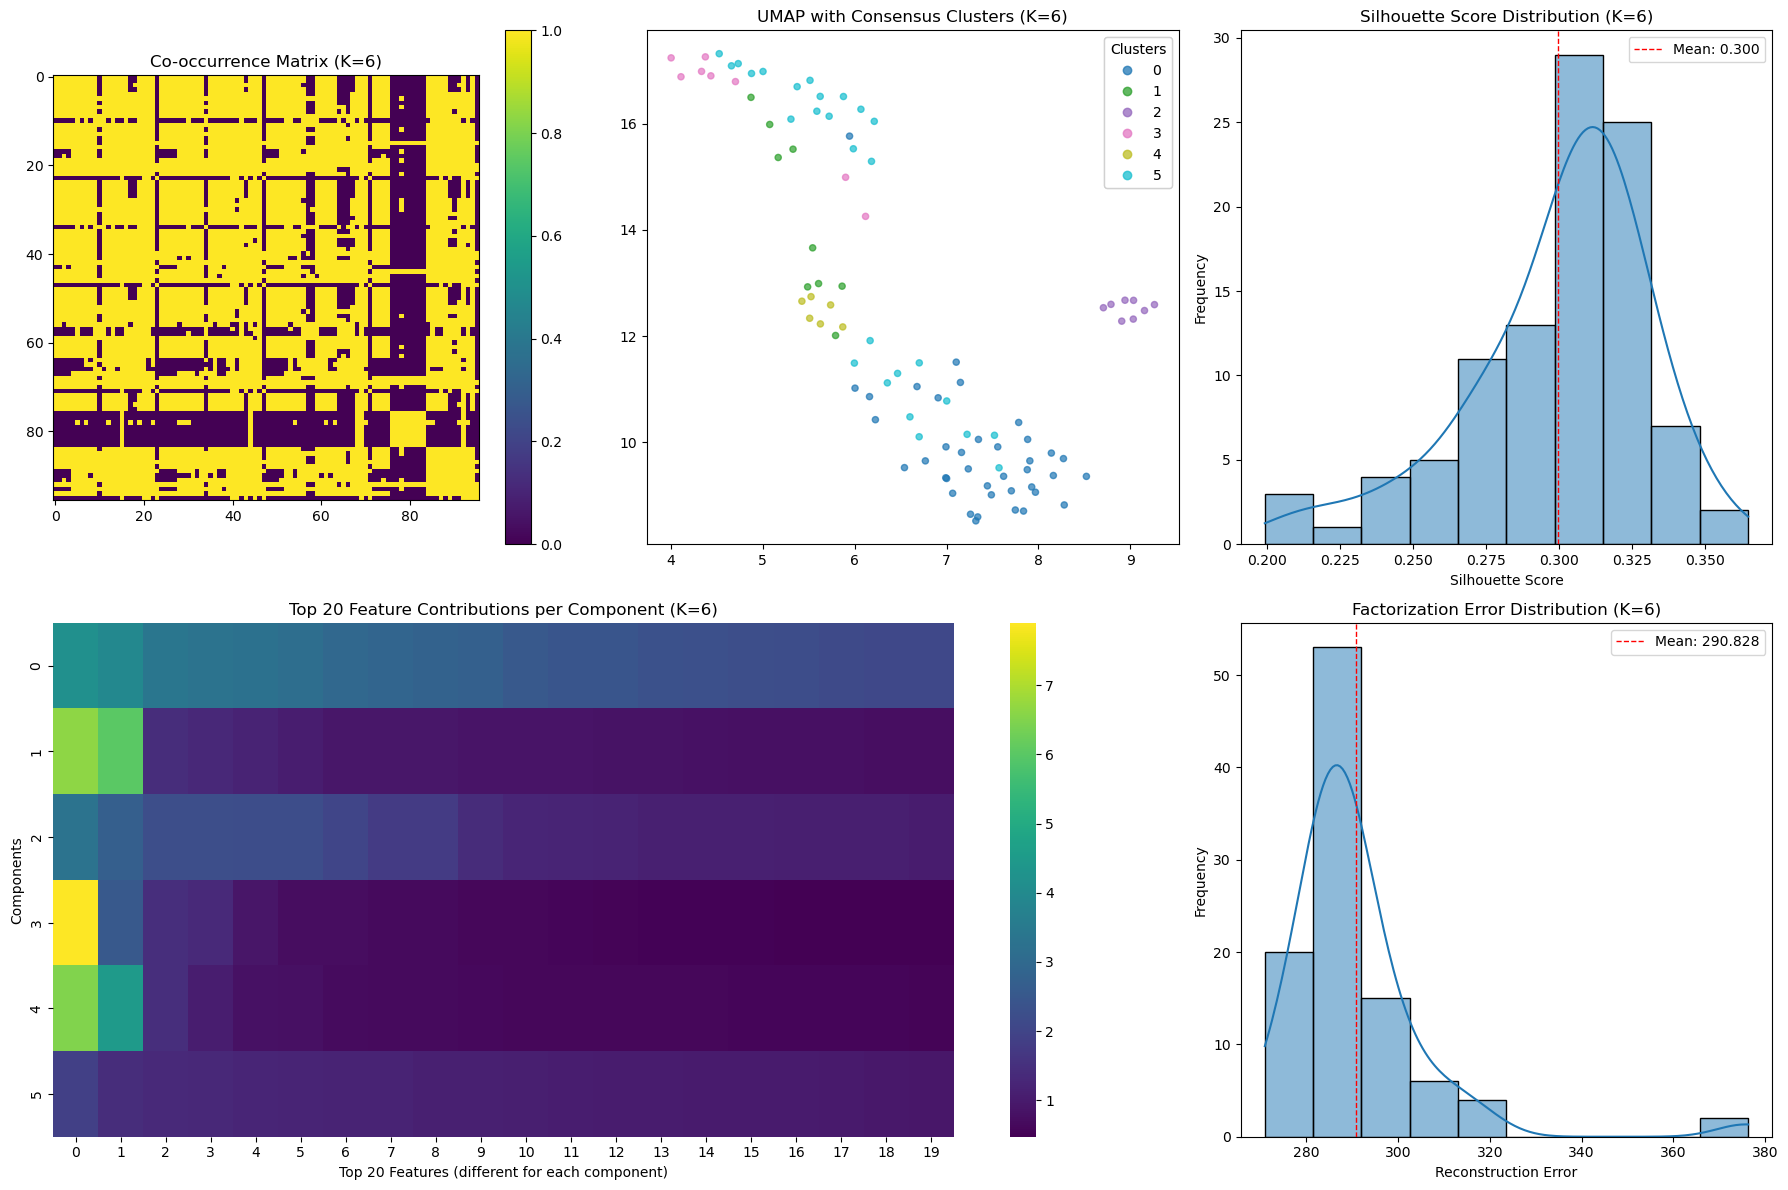

Running K=7
GMM normalization: Cutoff value = 930.02
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 857.89
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 930.15
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 862.41
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 917.99
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 904.46
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 955.03
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 891.99
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 935.46
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 891.16
GMM normalization: 59 samples scaled down out of 96 tota

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


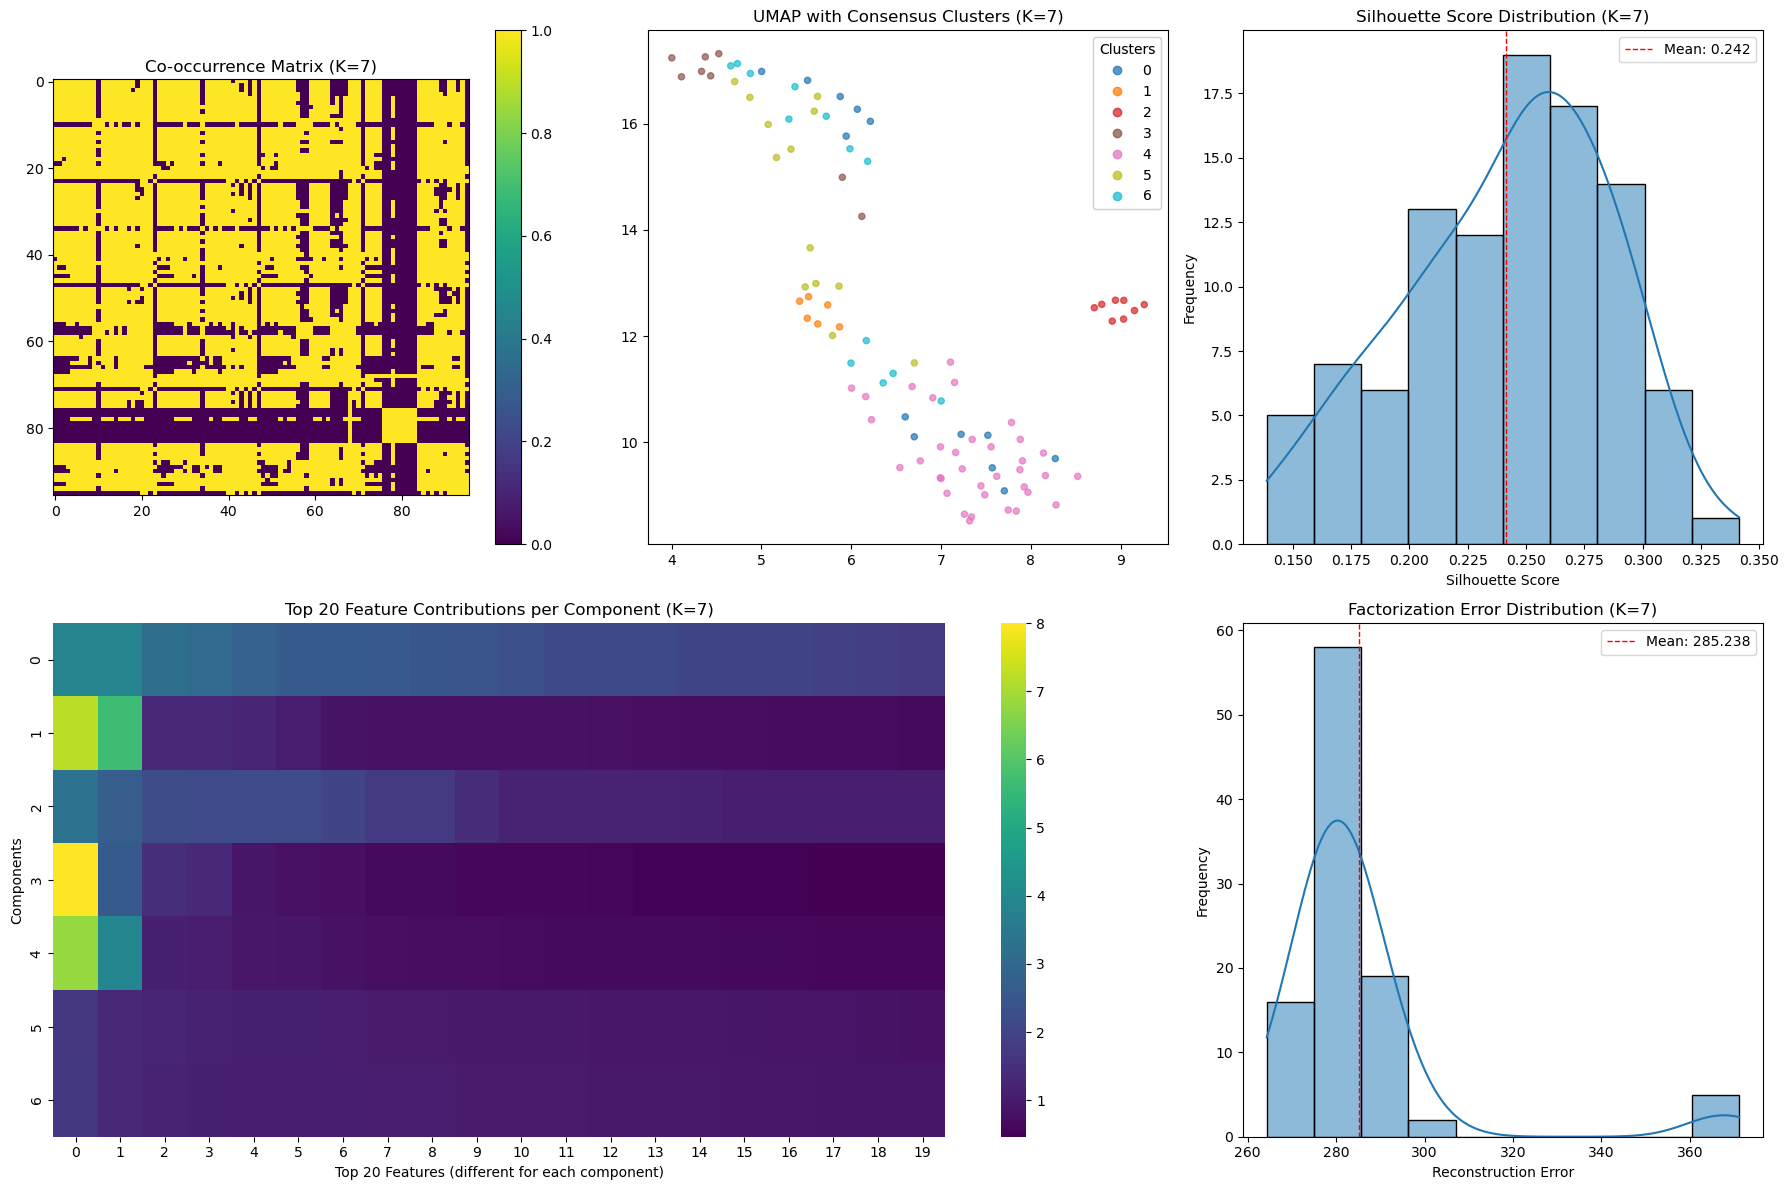

Running K=8
GMM normalization: Cutoff value = 1108.60
GMM normalization: 48 samples scaled down out of 96 total
GMM normalization: Cutoff value = 969.80
GMM normalization: 54 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1652.69
GMM normalization: 35 samples scaled down out of 96 total
GMM normalization: Cutoff value = 943.69
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 883.88
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 945.90
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 906.71
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 968.10
GMM normalization: 52 samples scaled down out of 96 total
GMM normalization: Cutoff value = 878.09
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 960.79
GMM normalization: 56 samples scaled down out of 96 to

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


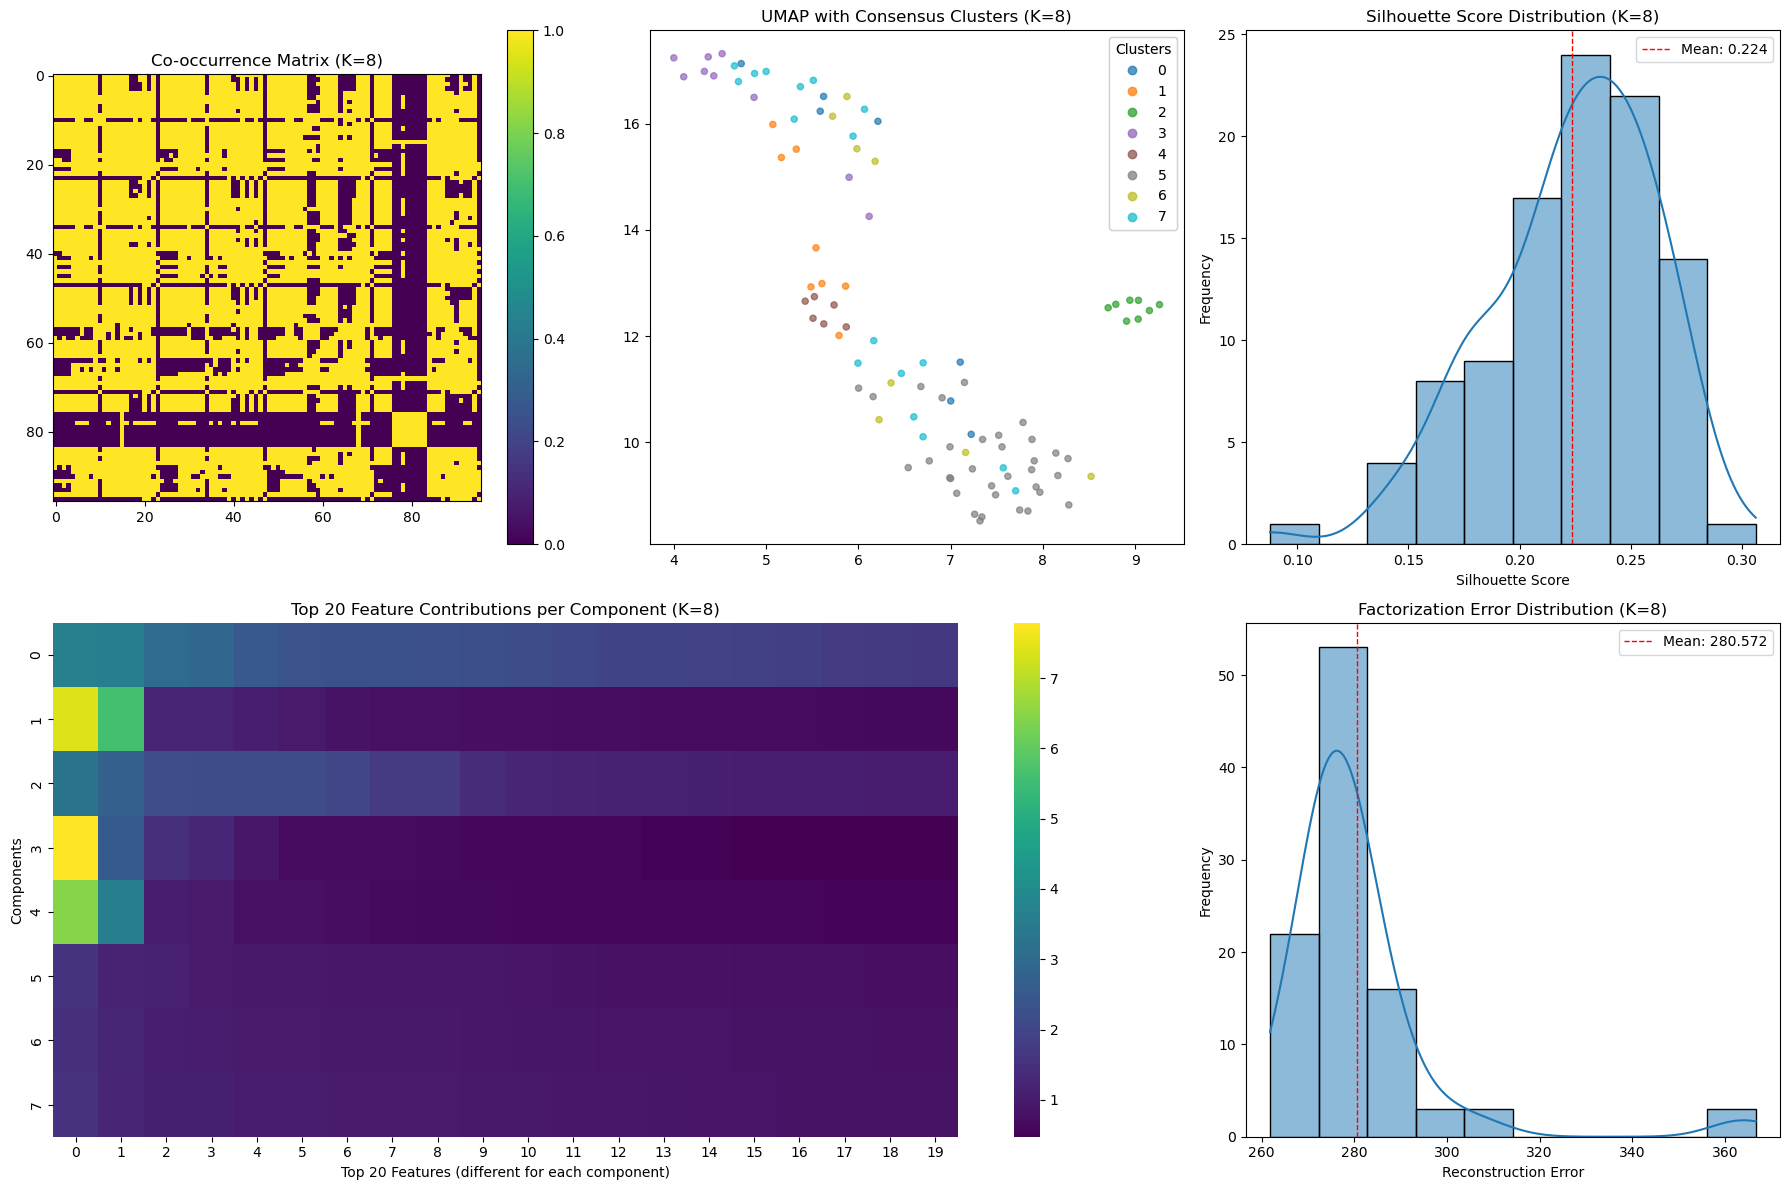

Running K=9
GMM normalization: Cutoff value = 889.07
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 903.69
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 948.46
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 939.93
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 961.37
GMM normalization: 54 samples scaled down out of 96 total
GMM normalization: Cutoff value = 932.21
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 856.76
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1004.39
GMM normalization: 52 samples scaled down out of 96 total
GMM normalization: Cutoff value = 900.27
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 873.21
GMM normalization: 60 samples scaled down out of 96 tot

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


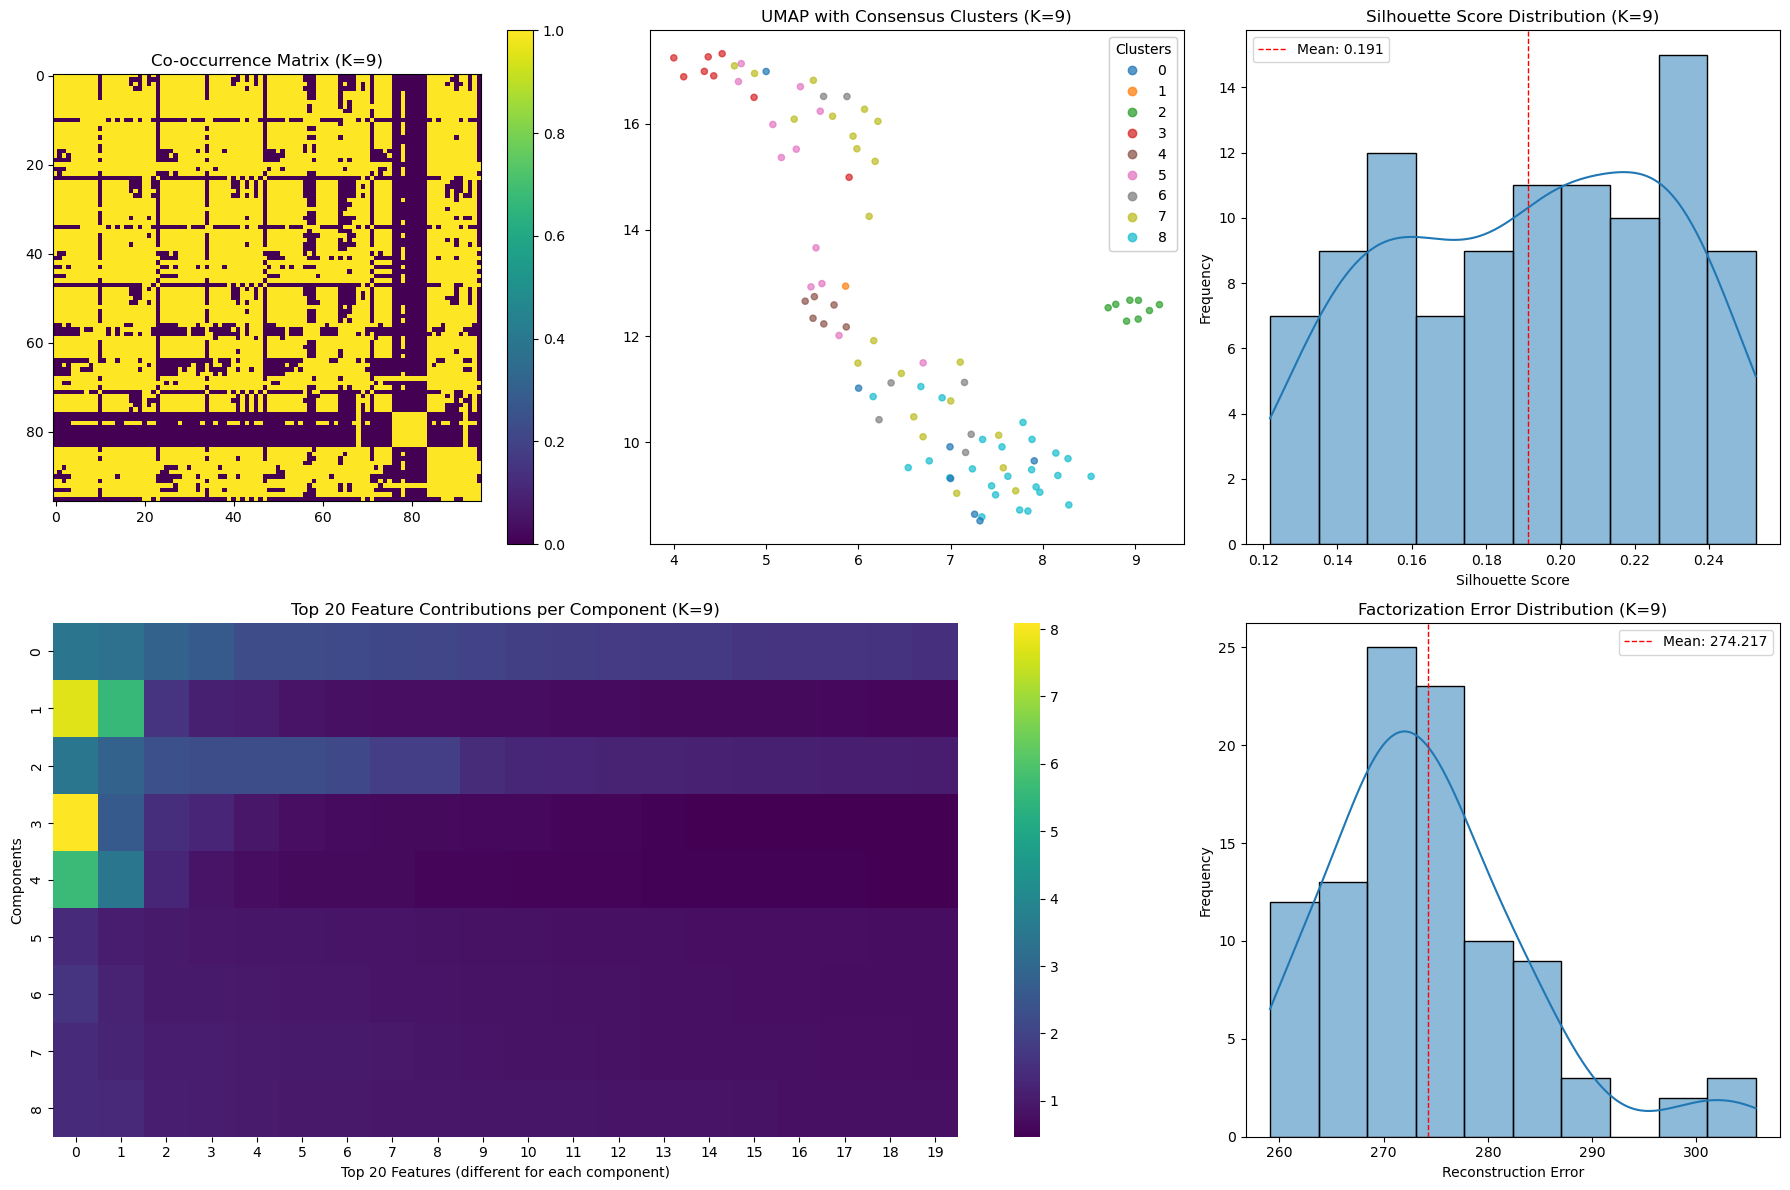

Running K=10
GMM normalization: Cutoff value = 898.64
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 925.05
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 905.20
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 950.63
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 937.93
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1043.02
GMM normalization: 49 samples scaled down out of 96 total
GMM normalization: Cutoff value = 908.31
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 906.92
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 954.11
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 982.04
GMM normalization: 55 samples scaled down out of 96 to

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


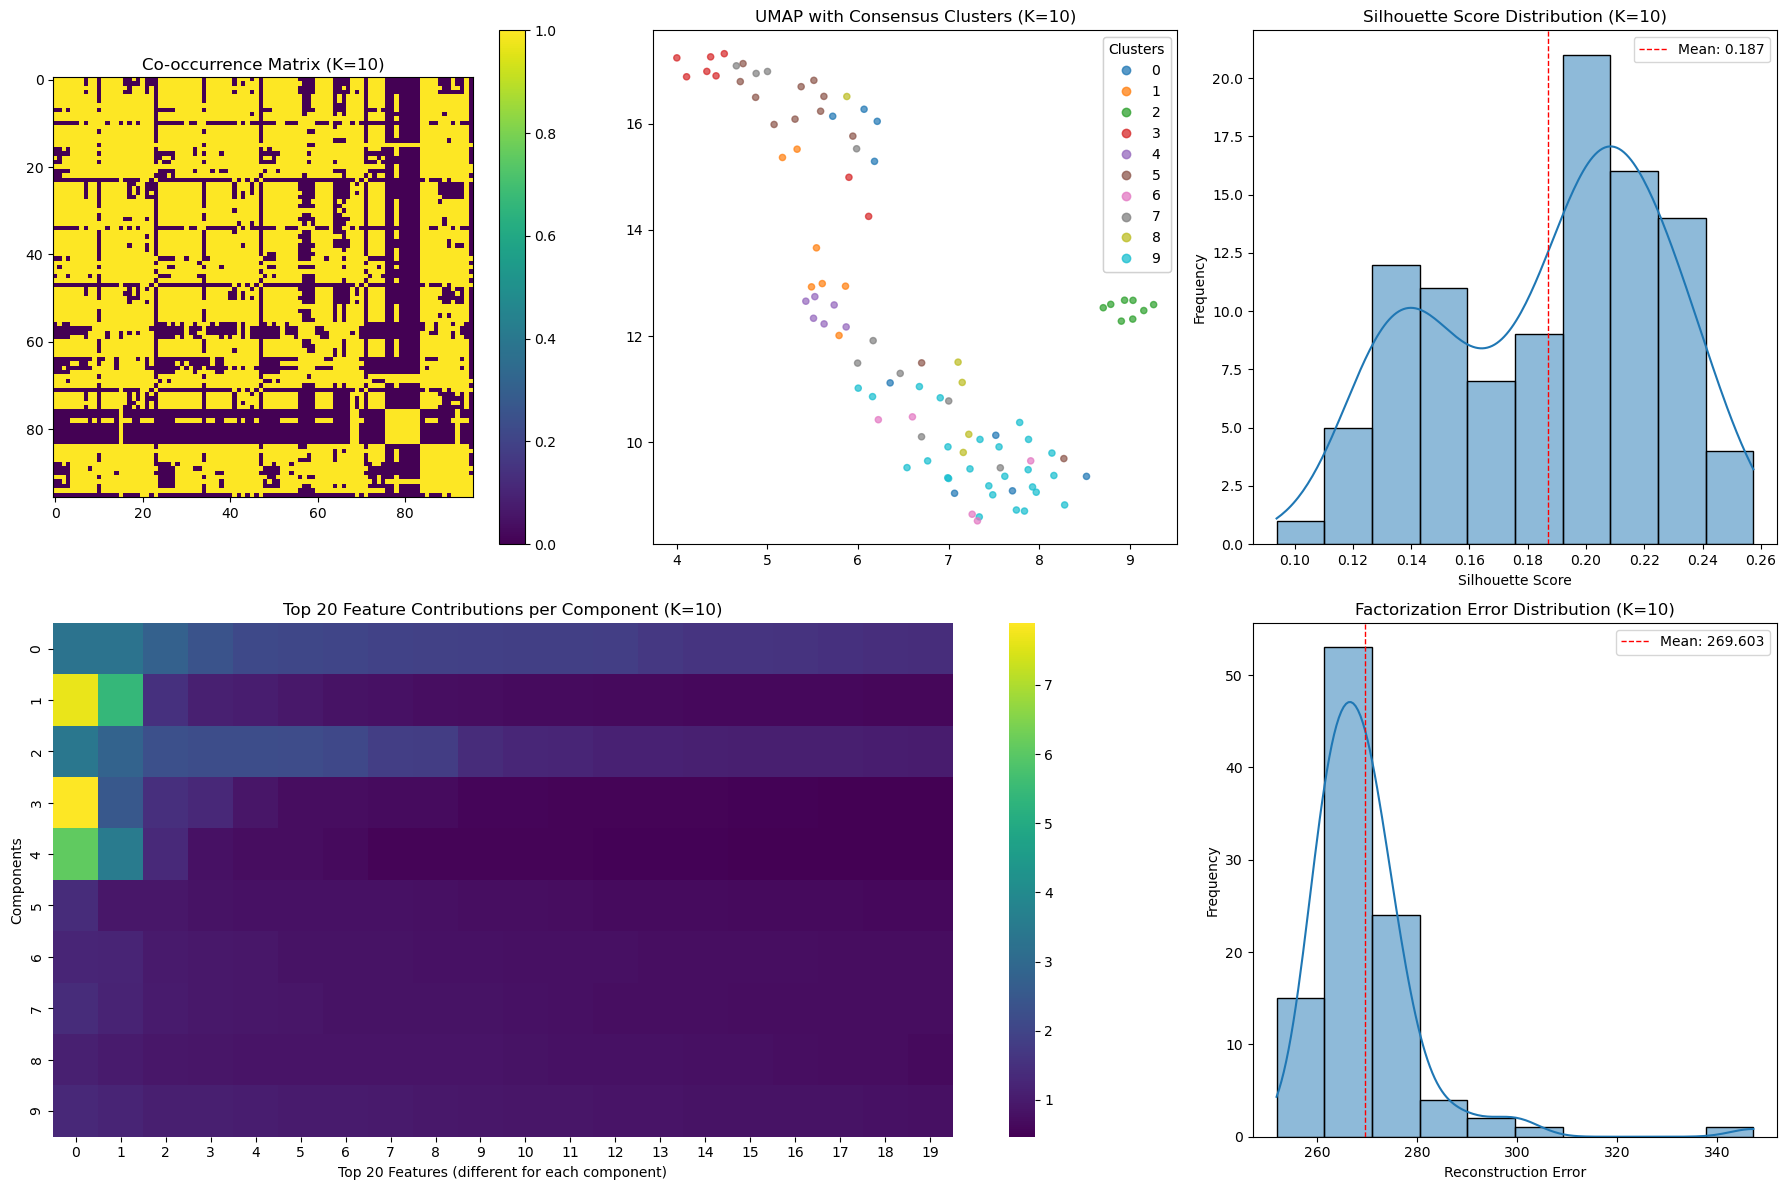

Running K=11
GMM normalization: Cutoff value = 932.03
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 890.09
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 919.41
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 876.44
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 966.69
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 924.76
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 903.02
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 960.28
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 991.04
GMM normalization: 53 samples scaled down out of 96 total
GMM normalization: Cutoff value = 903.96
GMM normalization: 57 samples scaled down out of 96 tot

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


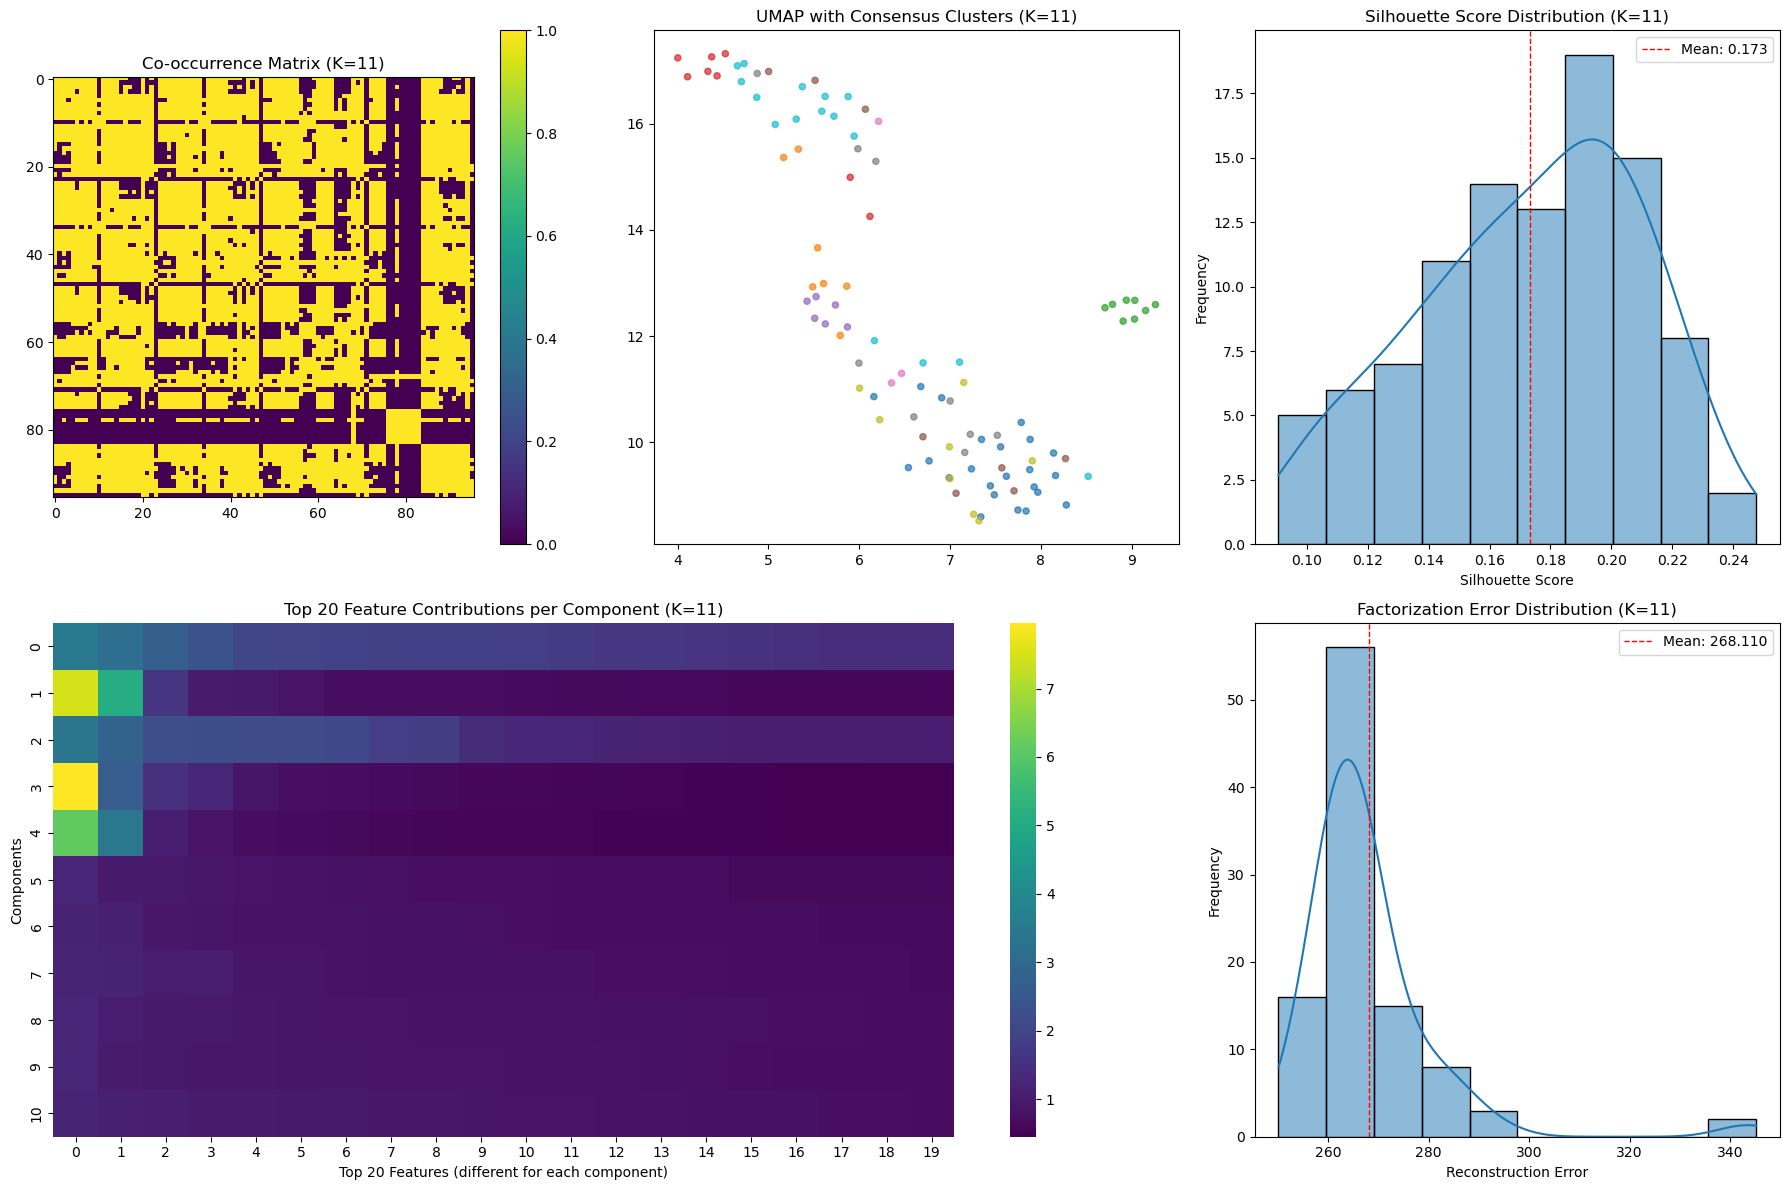

Running K=12
GMM normalization: Cutoff value = 953.29
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 927.76
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 997.38
GMM normalization: 54 samples scaled down out of 96 total
GMM normalization: Cutoff value = 919.77
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 875.77
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 943.74
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 904.12
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 858.21
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 913.09
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 944.51
GMM normalization: 57 samples scaled down out of 96 tot

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


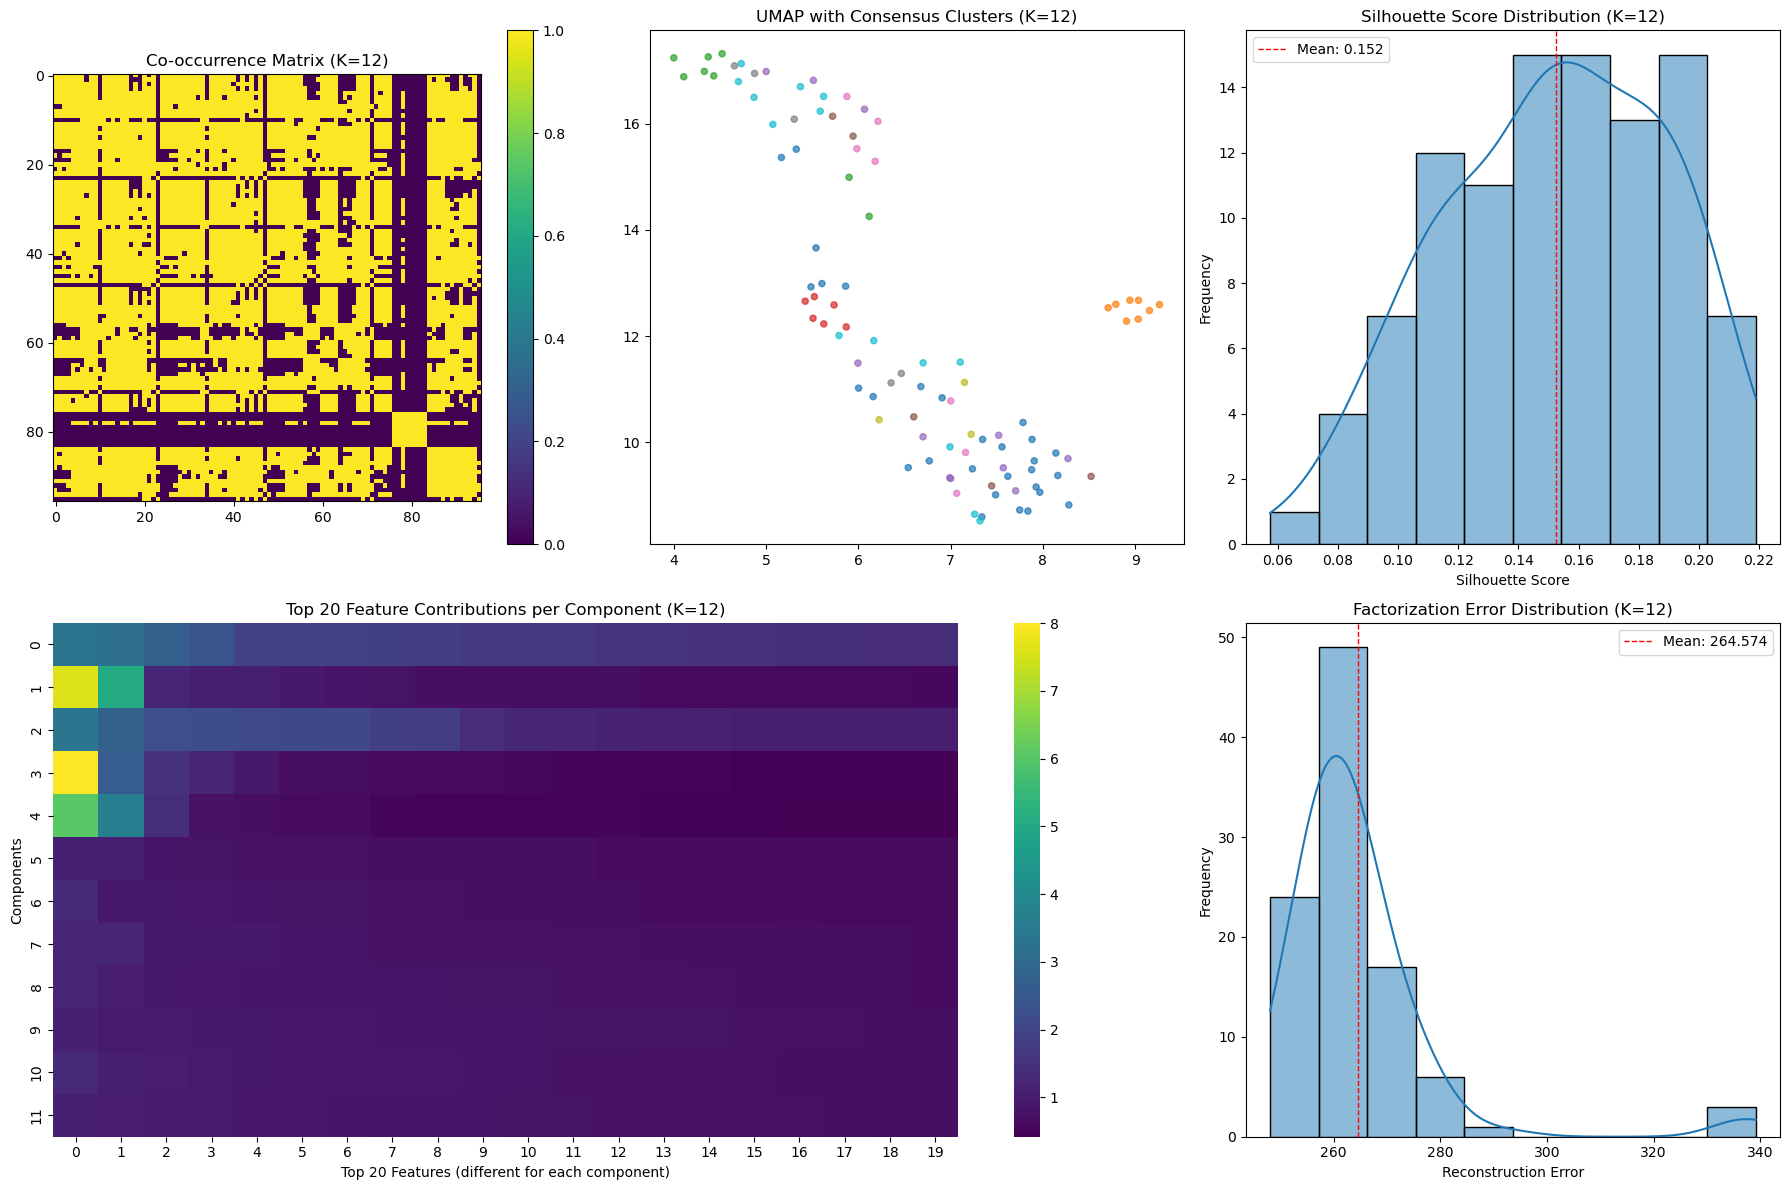

Running K=13
GMM normalization: Cutoff value = 874.48
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 948.75
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 931.16
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 914.54
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 934.63
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1113.17
GMM normalization: 49 samples scaled down out of 96 total
GMM normalization: Cutoff value = 898.70
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 911.43
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 915.39
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 902.84
GMM normalization: 57 samples scaled down out of 96 to

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


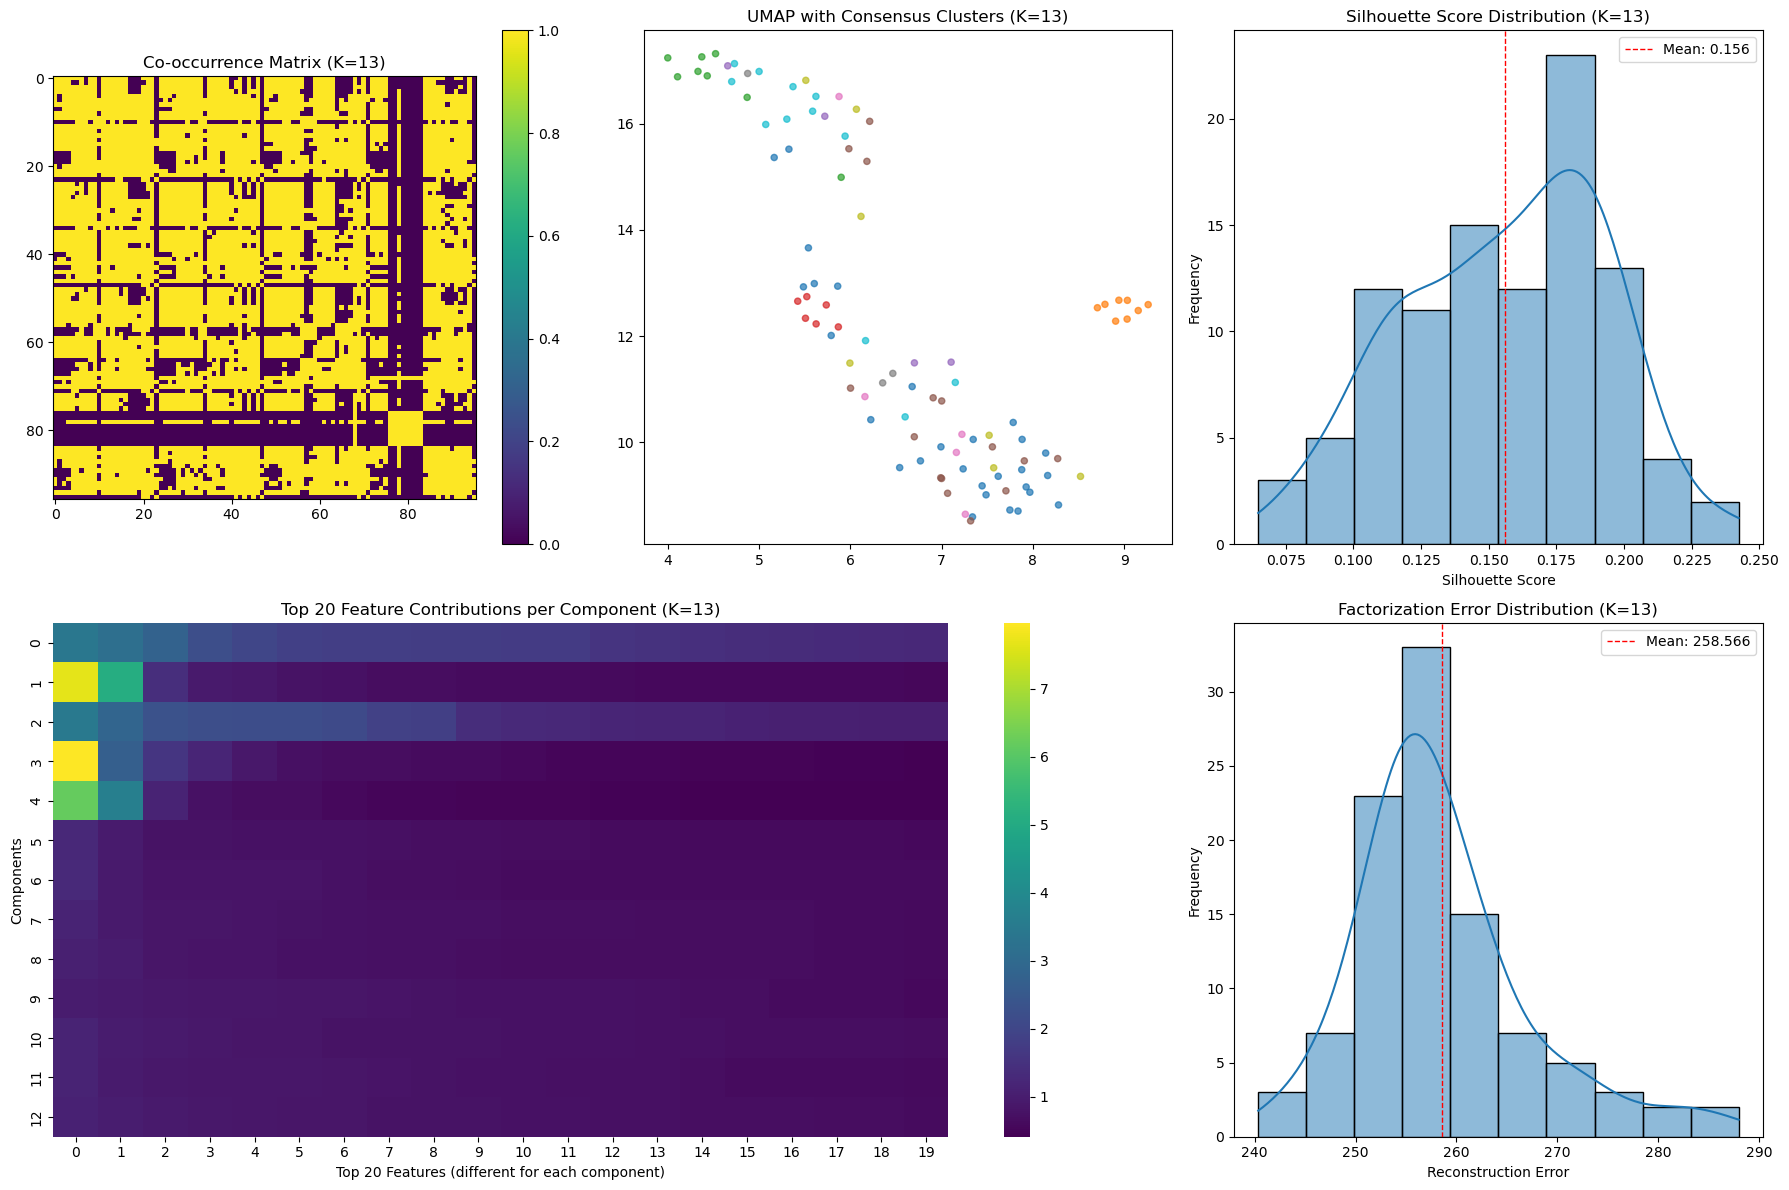

Running K=14
GMM normalization: Cutoff value = 923.90
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 895.46
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1664.33
GMM normalization: 35 samples scaled down out of 96 total
GMM normalization: Cutoff value = 918.61
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 860.30
GMM normalization: 62 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1652.16
GMM normalization: 36 samples scaled down out of 96 total
GMM normalization: Cutoff value = 880.19
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 912.72
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 940.69
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 964.43
GMM normalization: 53 samples scaled down out of 96 t

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


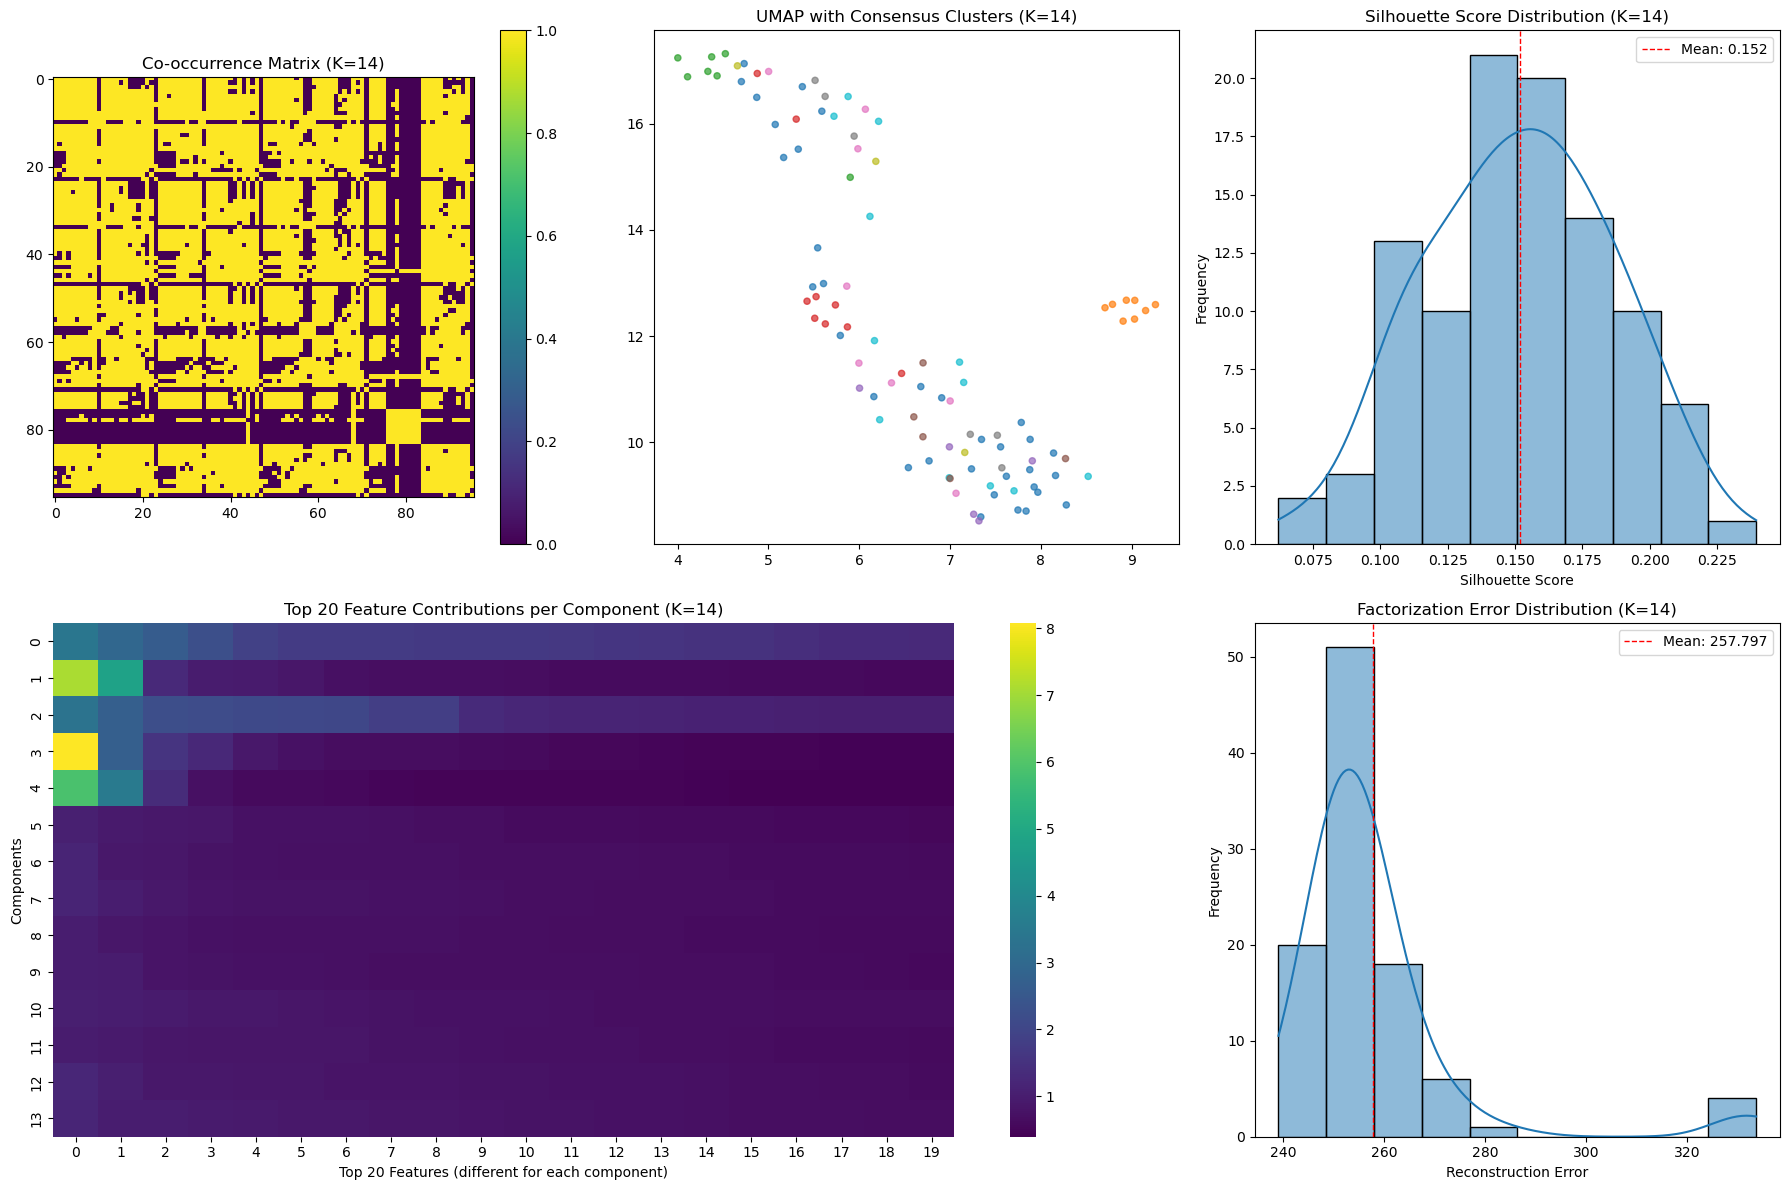

Running K=15
GMM normalization: Cutoff value = 908.78
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 928.43
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 851.63
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 944.00
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 931.97
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1000.92
GMM normalization: 54 samples scaled down out of 96 total
GMM normalization: Cutoff value = 865.75
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 889.95
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 912.41
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 917.69
GMM normalization: 57 samples scaled down out of 96 to

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


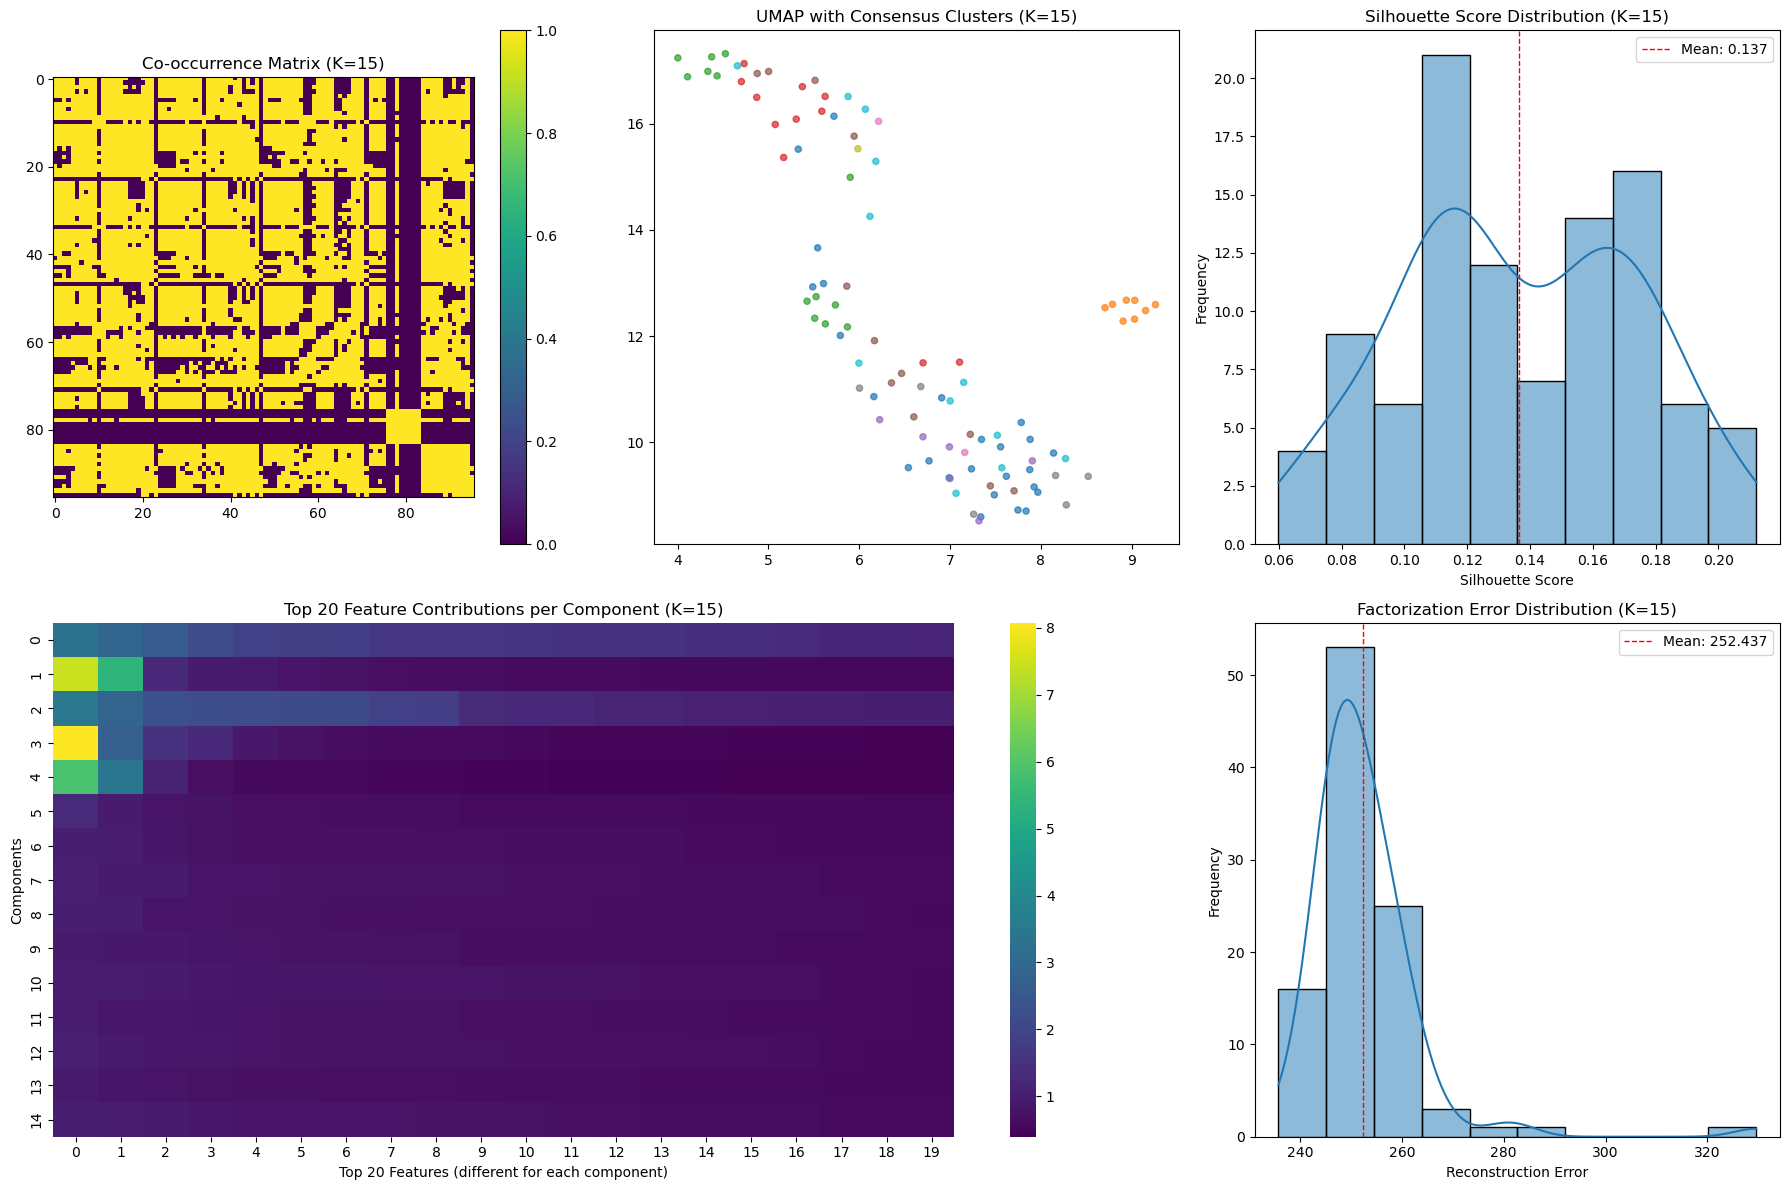

Running K=16
GMM normalization: Cutoff value = 892.90
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 911.02
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 855.14
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 871.27
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 957.57
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 884.78
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 912.12
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 962.46
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 913.78
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 948.35
GMM normalization: 54 samples scaled down out of 96 tot

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


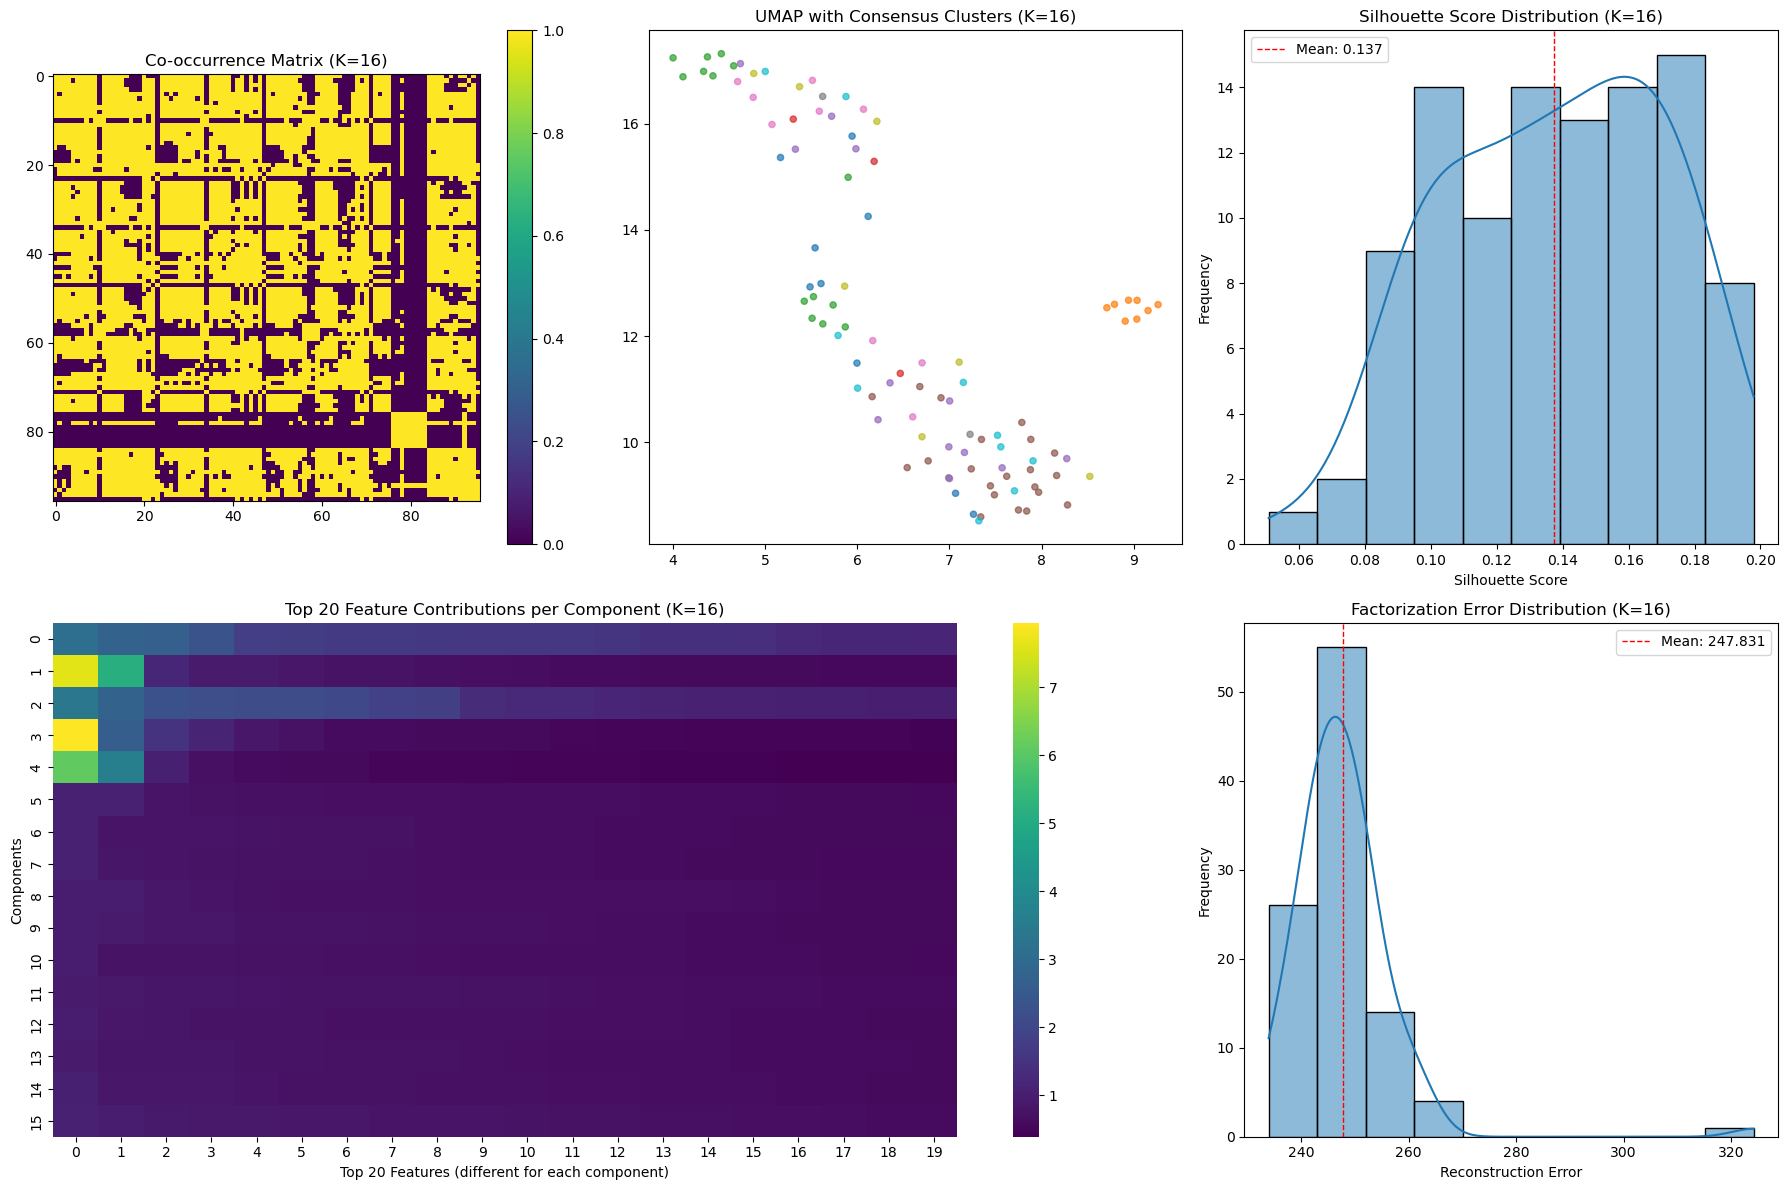

Running K=17
GMM normalization: Cutoff value = 947.97
GMM normalization: 54 samples scaled down out of 96 total
GMM normalization: Cutoff value = 924.60
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 965.61
GMM normalization: 54 samples scaled down out of 96 total
GMM normalization: Cutoff value = 874.51
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 976.07
GMM normalization: 54 samples scaled down out of 96 total
GMM normalization: Cutoff value = 885.79
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 933.99
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 937.27
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 890.72
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 902.84
GMM normalization: 59 samples scaled down out of 96 tot

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


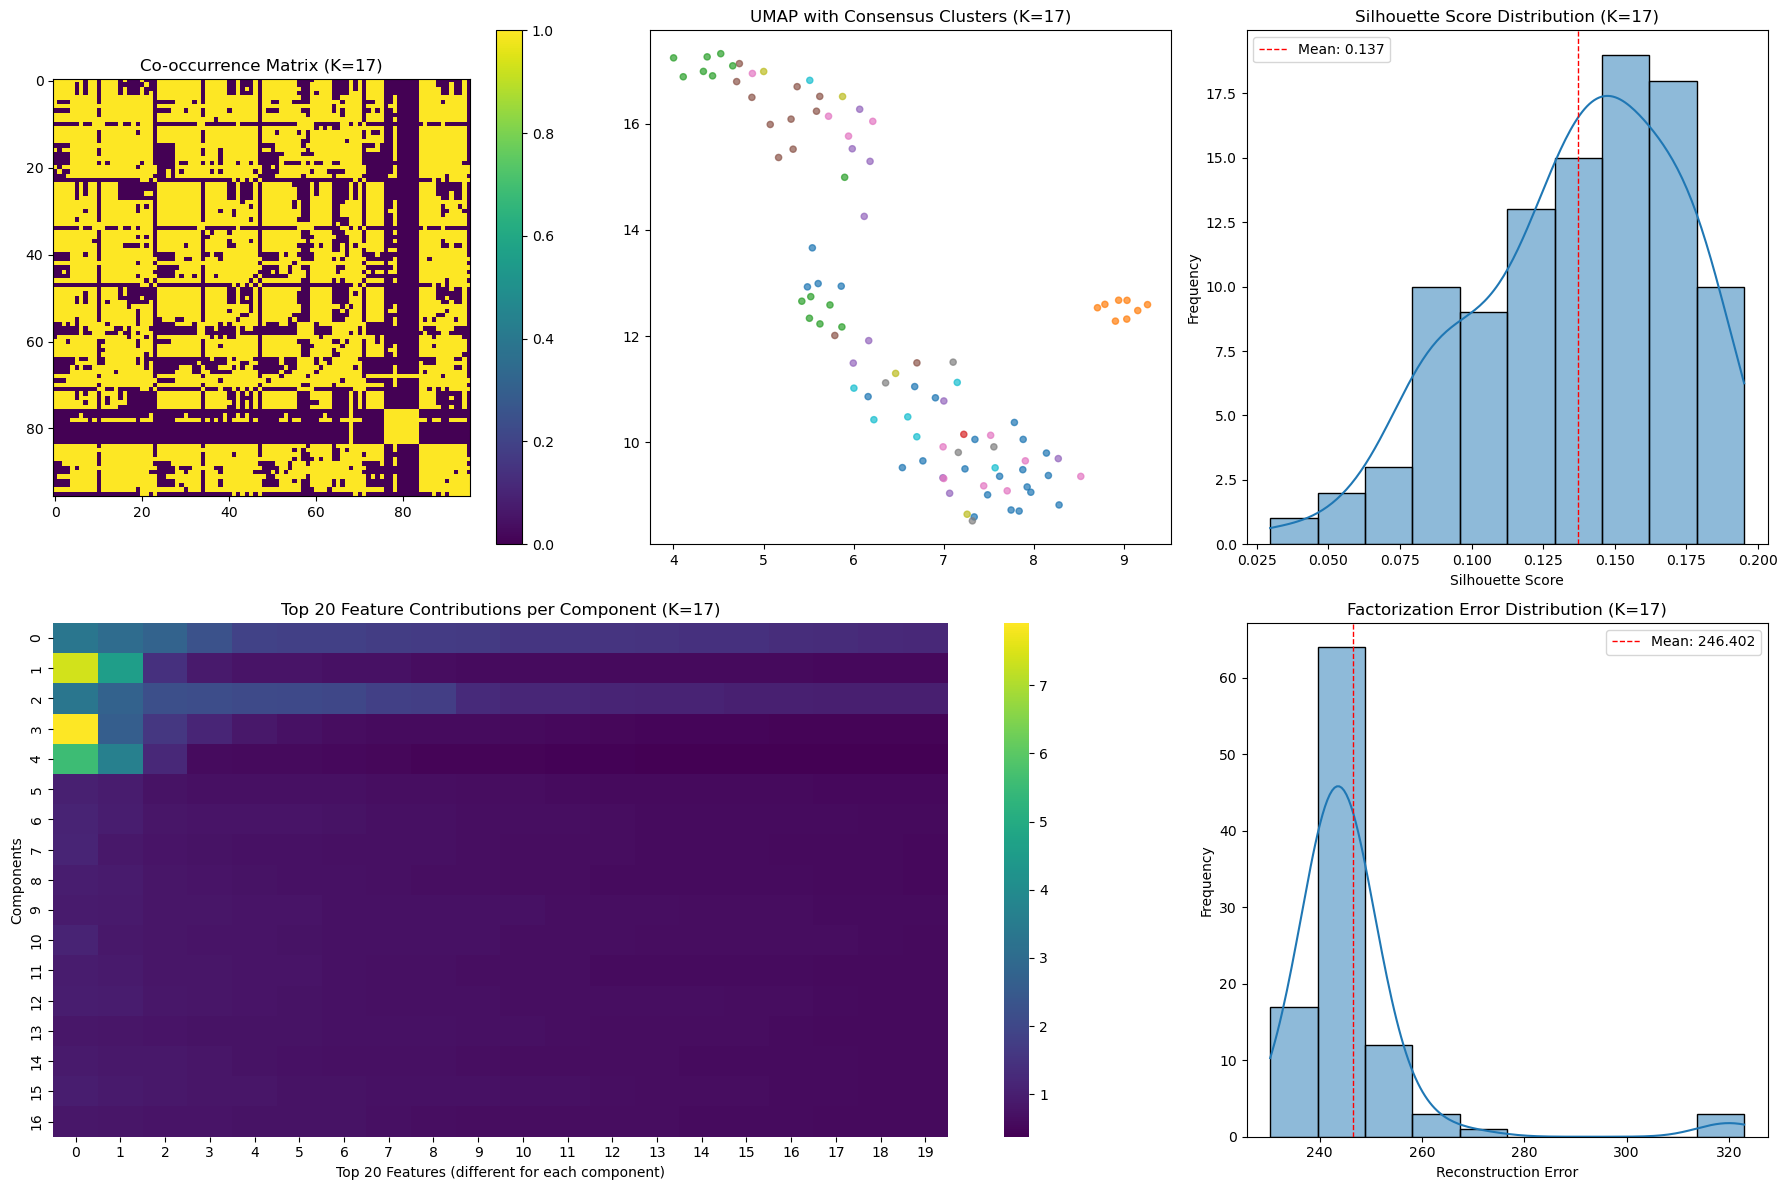

Running K=18
GMM normalization: Cutoff value = 907.23
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 938.23
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1075.08
GMM normalization: 48 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1134.42
GMM normalization: 48 samples scaled down out of 96 total
GMM normalization: Cutoff value = 941.33
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 947.19
GMM normalization: 54 samples scaled down out of 96 total
GMM normalization: Cutoff value = 892.22
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 979.64
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 849.46
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 927.00
GMM normalization: 58 samples scaled down out of 96 t

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


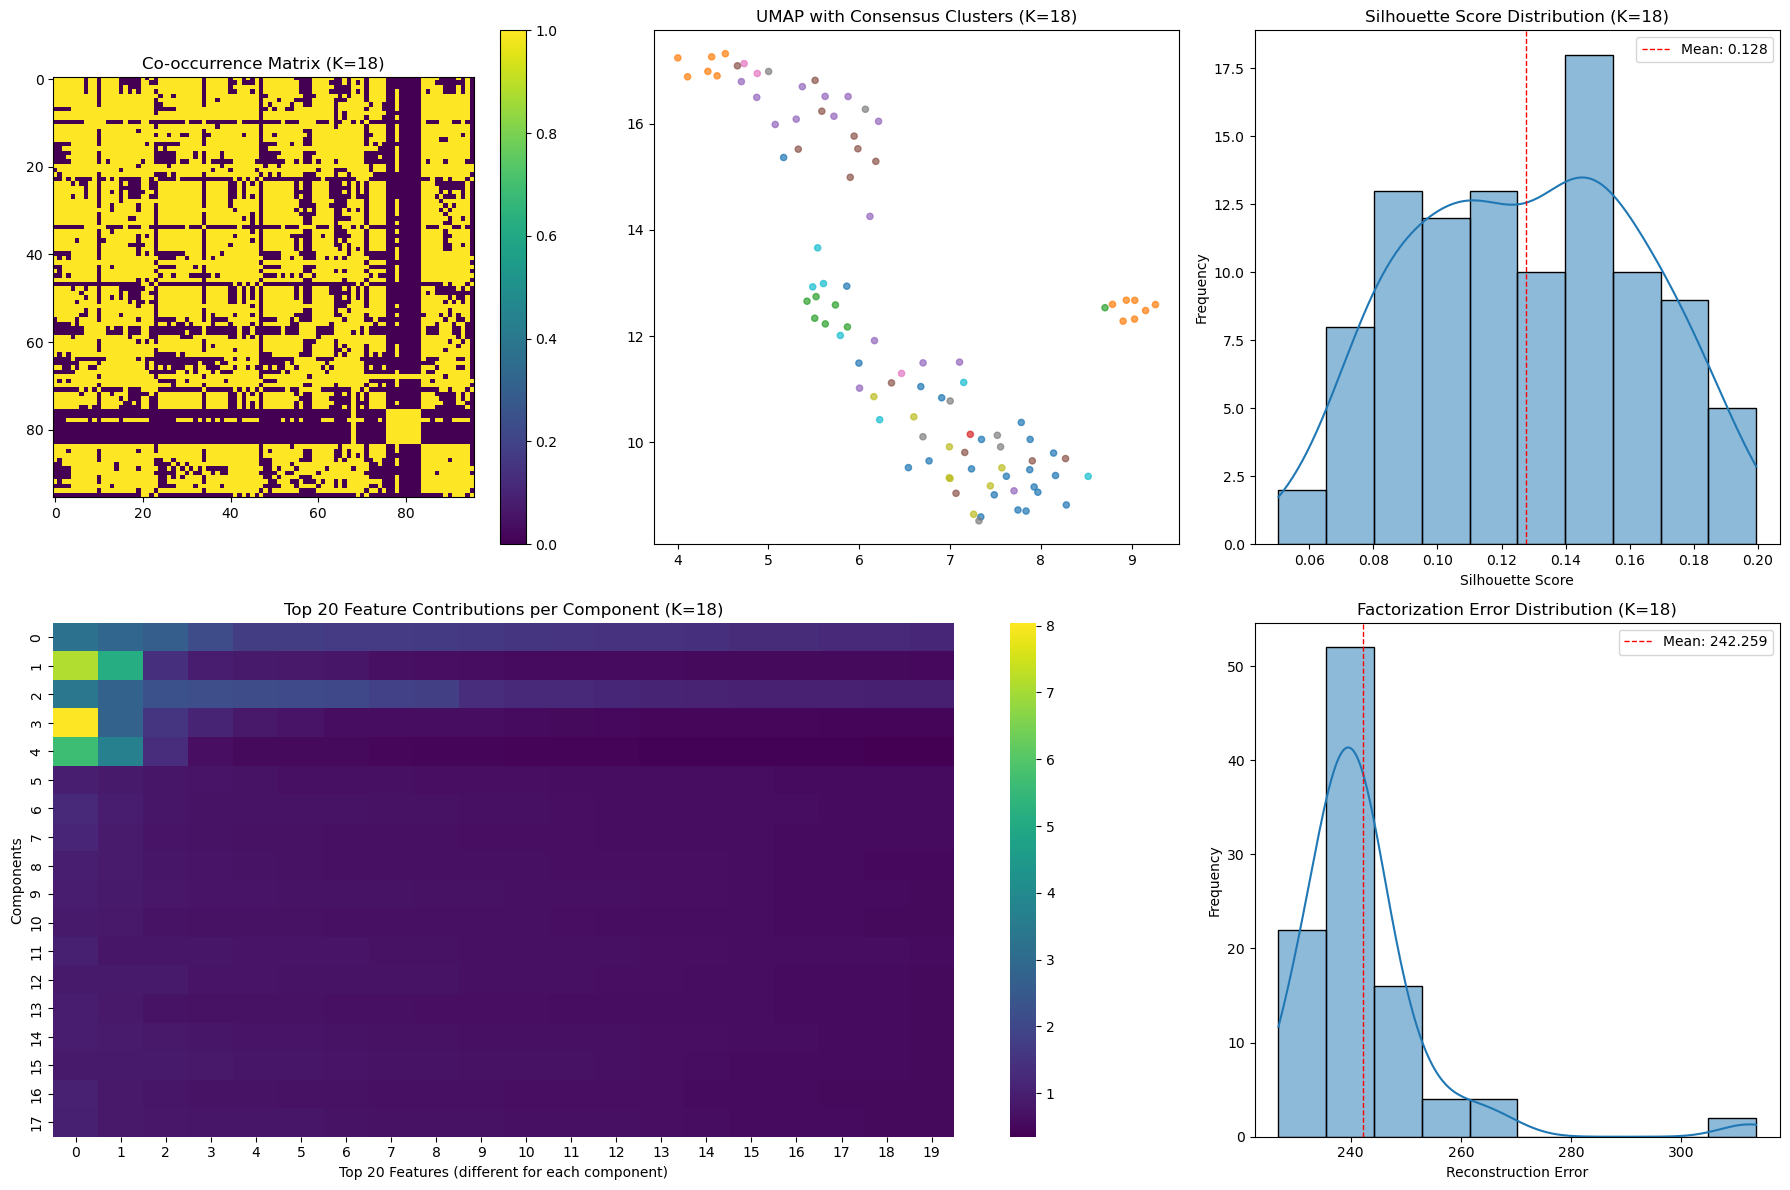

Running K=19
GMM normalization: Cutoff value = 846.70
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 918.08
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 922.19
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 904.56
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 939.83
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 916.35
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1655.70
GMM normalization: 35 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1014.17
GMM normalization: 53 samples scaled down out of 96 total
GMM normalization: Cutoff value = 918.07
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 918.07
GMM normalization: 60 samples scaled down out of 96 t

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


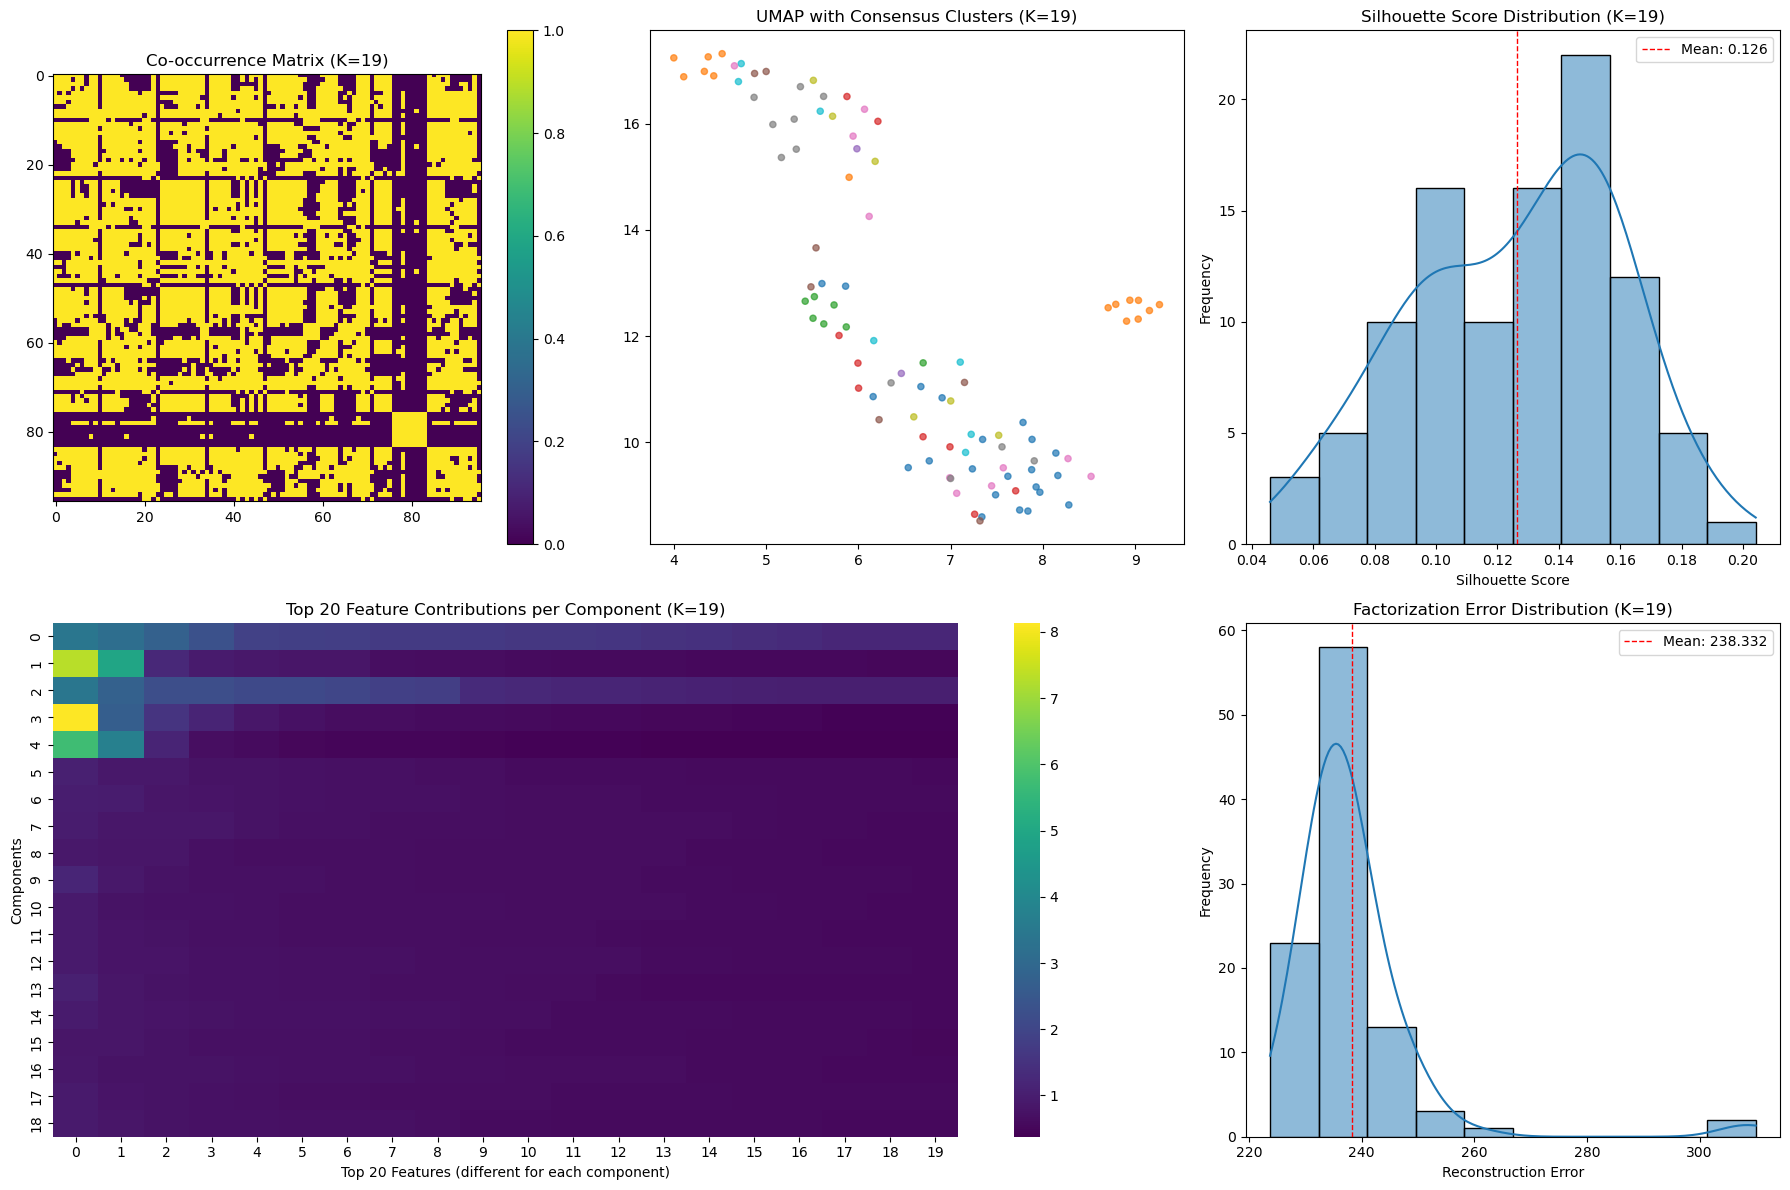

Running K=20
GMM normalization: Cutoff value = 884.00
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1057.63
GMM normalization: 50 samples scaled down out of 96 total
GMM normalization: Cutoff value = 919.39
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 883.30
GMM normalization: 60 samples scaled down out of 96 total
GMM normalization: Cutoff value = 862.20
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 916.63
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 948.10
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 921.18
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1003.36
GMM normalization: 53 samples scaled down out of 96 total
GMM normalization: Cutoff value = 908.09
GMM normalization: 58 samples scaled down out of 96 t

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


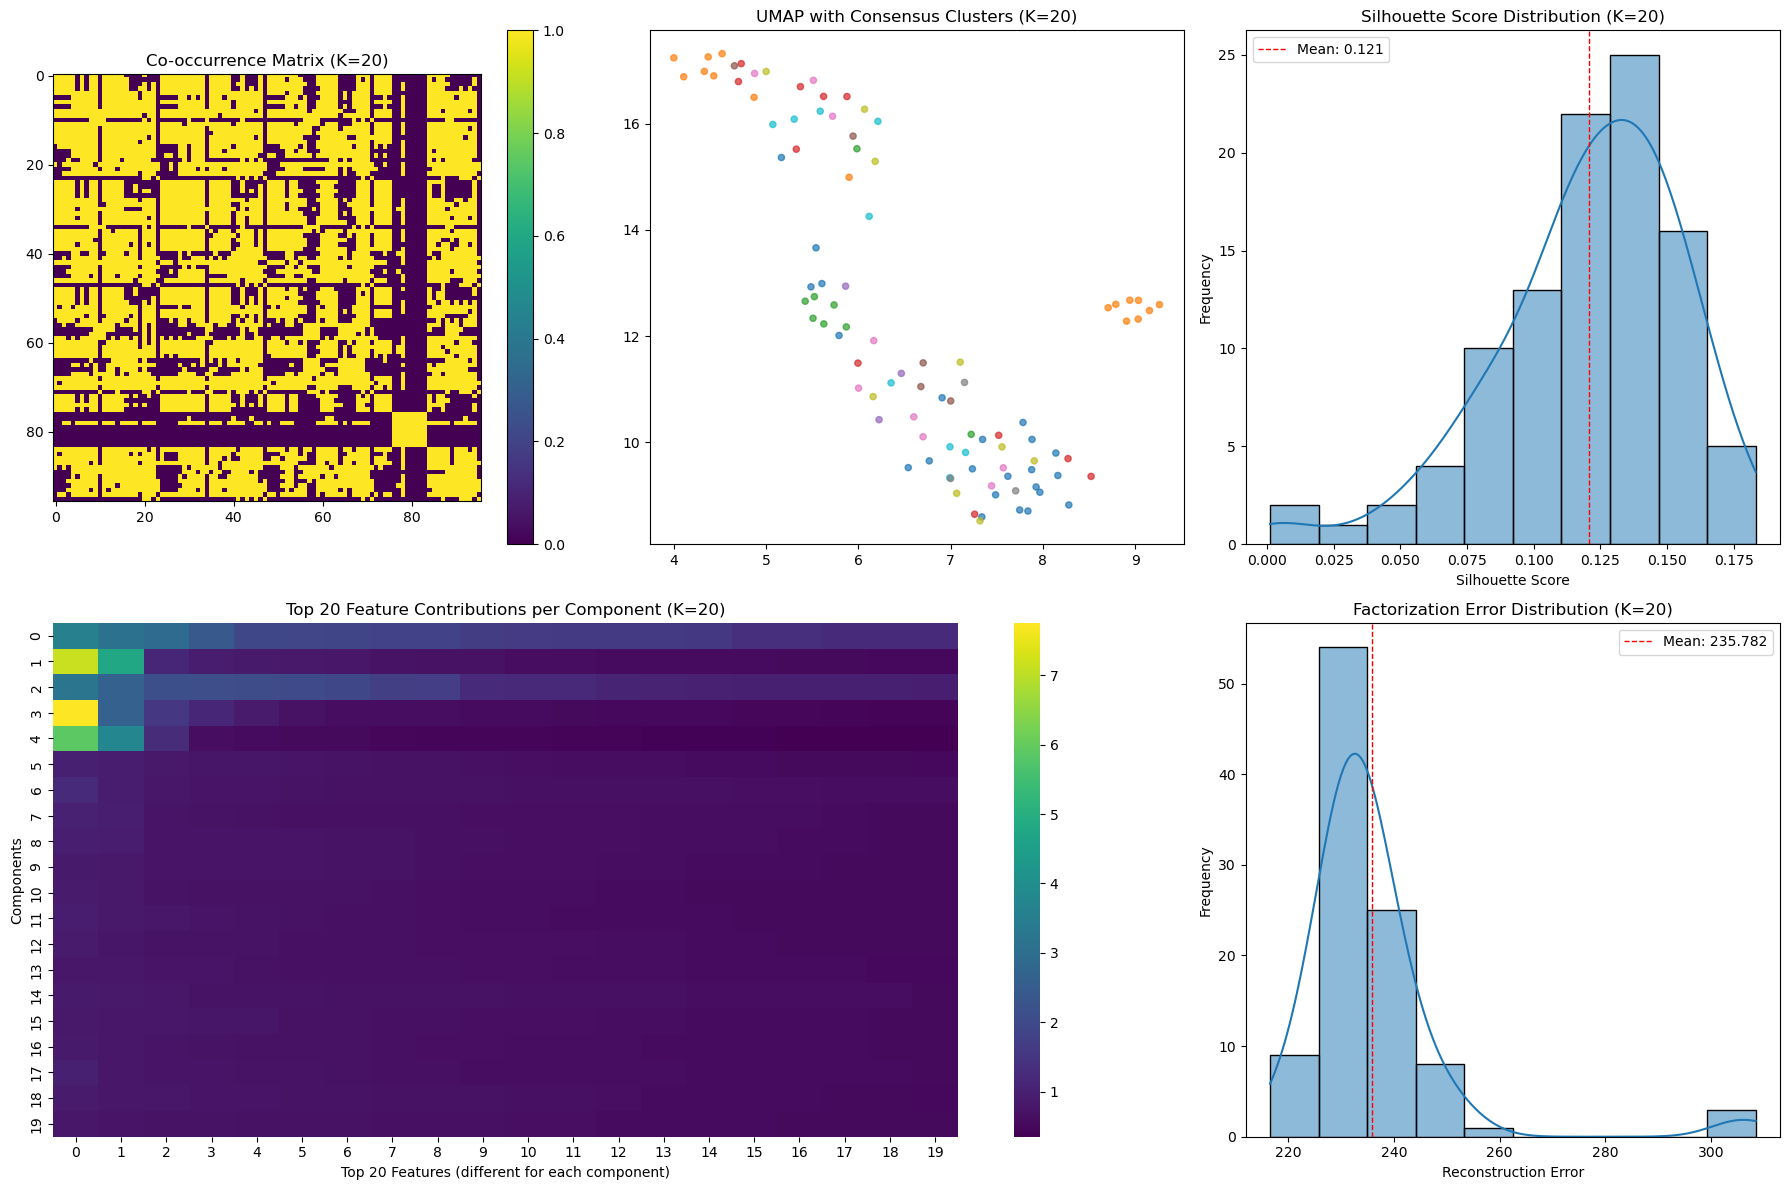

Running K=21
GMM normalization: Cutoff value = 927.59
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 979.85
GMM normalization: 54 samples scaled down out of 96 total
GMM normalization: Cutoff value = 900.48
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 882.17
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1027.92
GMM normalization: 53 samples scaled down out of 96 total
GMM normalization: Cutoff value = 915.91
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 944.60
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1046.84
GMM normalization: 52 samples scaled down out of 96 total
GMM normalization: Cutoff value = 956.52
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 966.98
GMM normalization: 54 samples scaled down out of 96 t

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


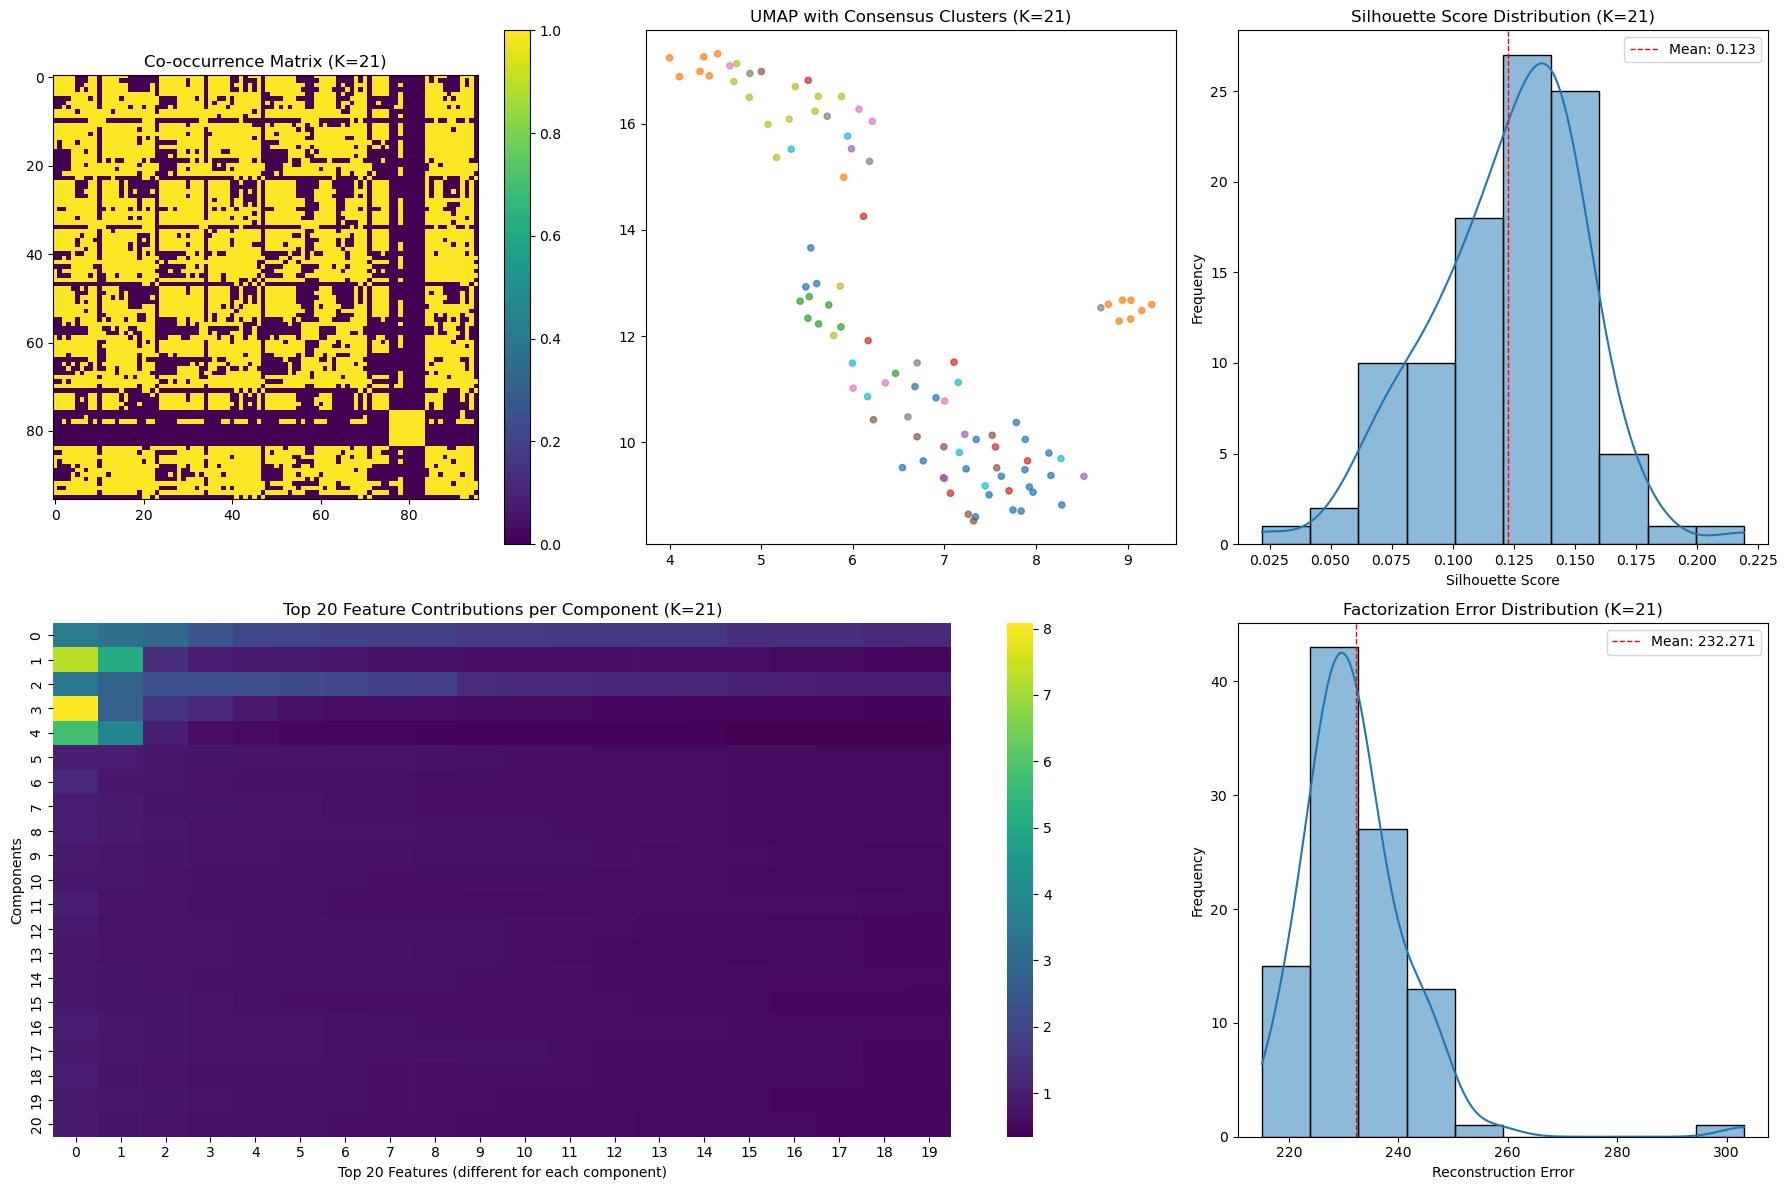

Running K=22
GMM normalization: Cutoff value = 941.95
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1645.28
GMM normalization: 35 samples scaled down out of 96 total
GMM normalization: Cutoff value = 914.84
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1722.46
GMM normalization: 34 samples scaled down out of 96 total
GMM normalization: Cutoff value = 929.26
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 878.24
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1012.05
GMM normalization: 52 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1037.04
GMM normalization: 51 samples scaled down out of 96 total
GMM normalization: Cutoff value = 878.62
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 916.52
GMM normalization: 59 samples scaled down out of 96

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


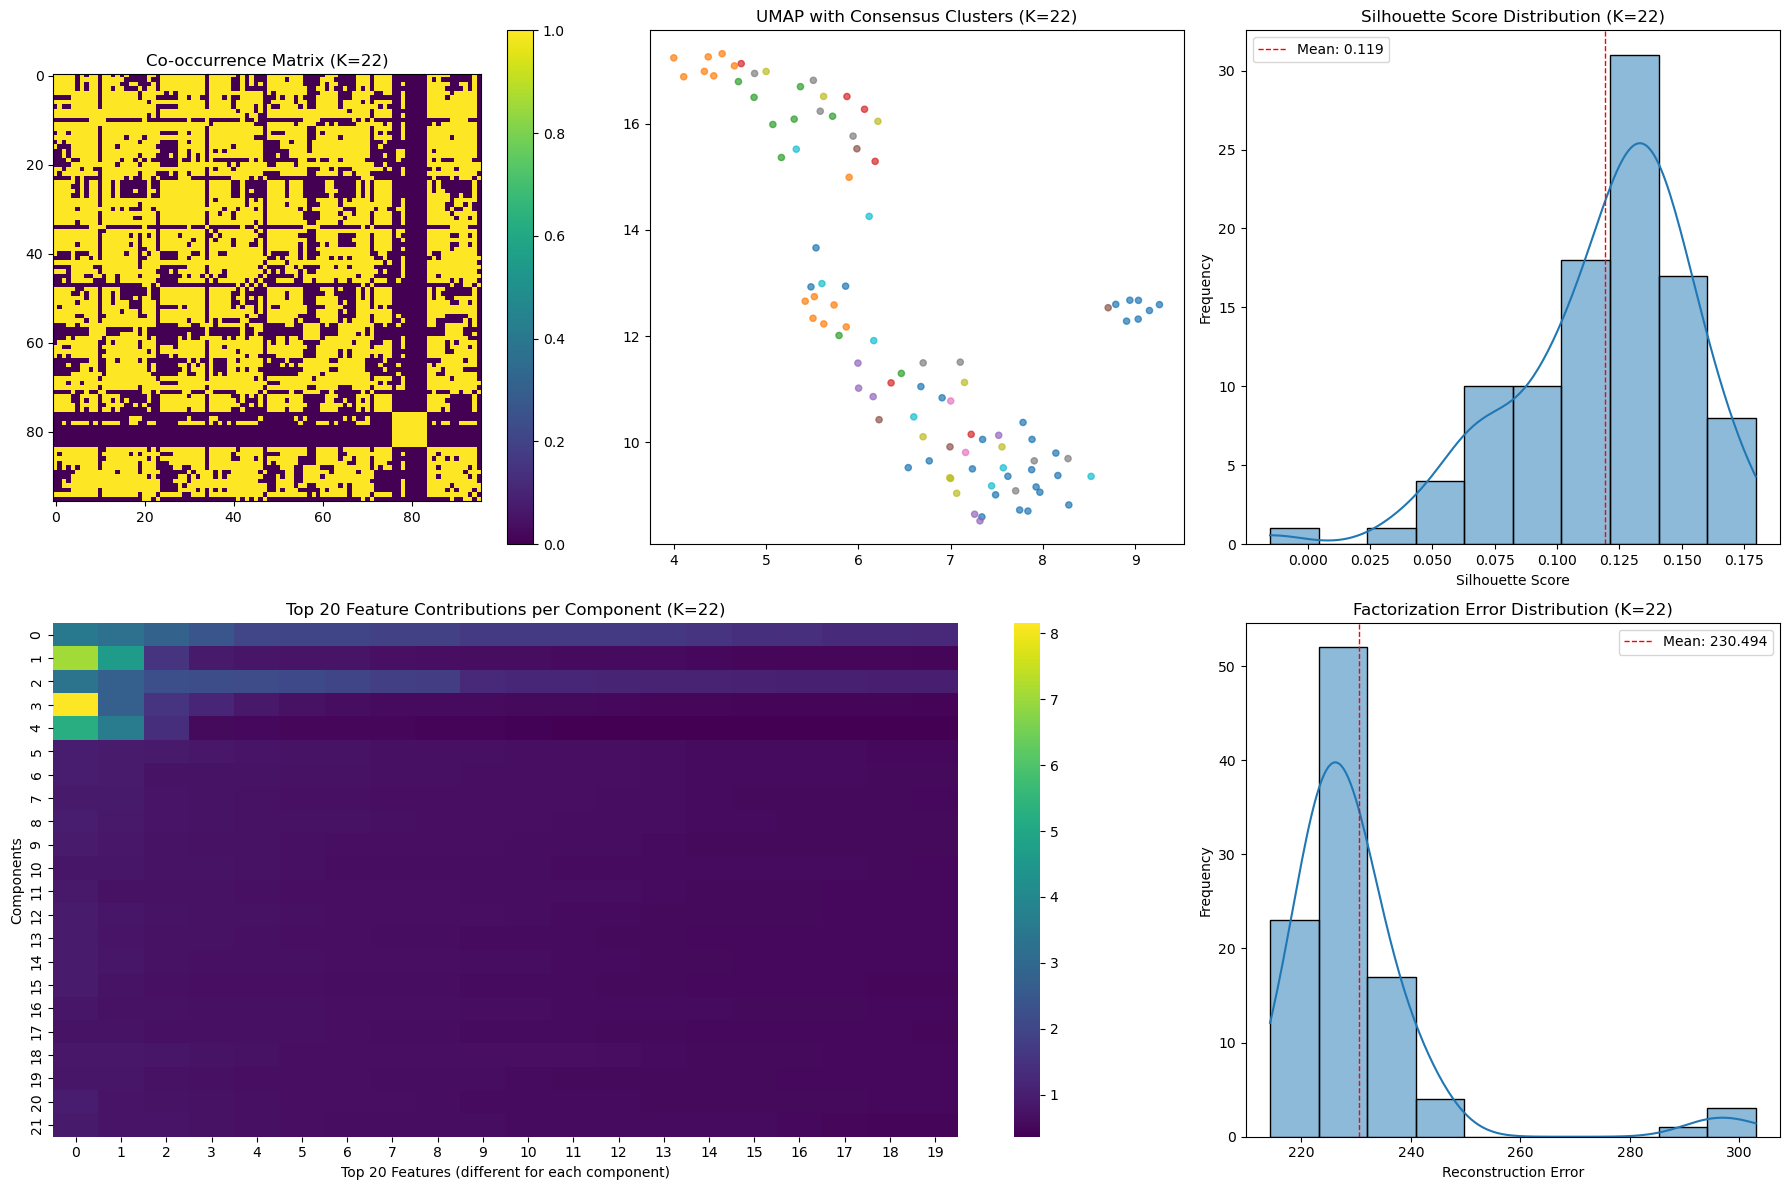

Running K=23
GMM normalization: Cutoff value = 945.10
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 903.46
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 861.42
GMM normalization: 61 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1659.11
GMM normalization: 36 samples scaled down out of 96 total
GMM normalization: Cutoff value = 957.42
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1069.10
GMM normalization: 50 samples scaled down out of 96 total
GMM normalization: Cutoff value = 938.09
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 922.19
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 937.62
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1020.36
GMM normalization: 50 samples scaled down out of 96 

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


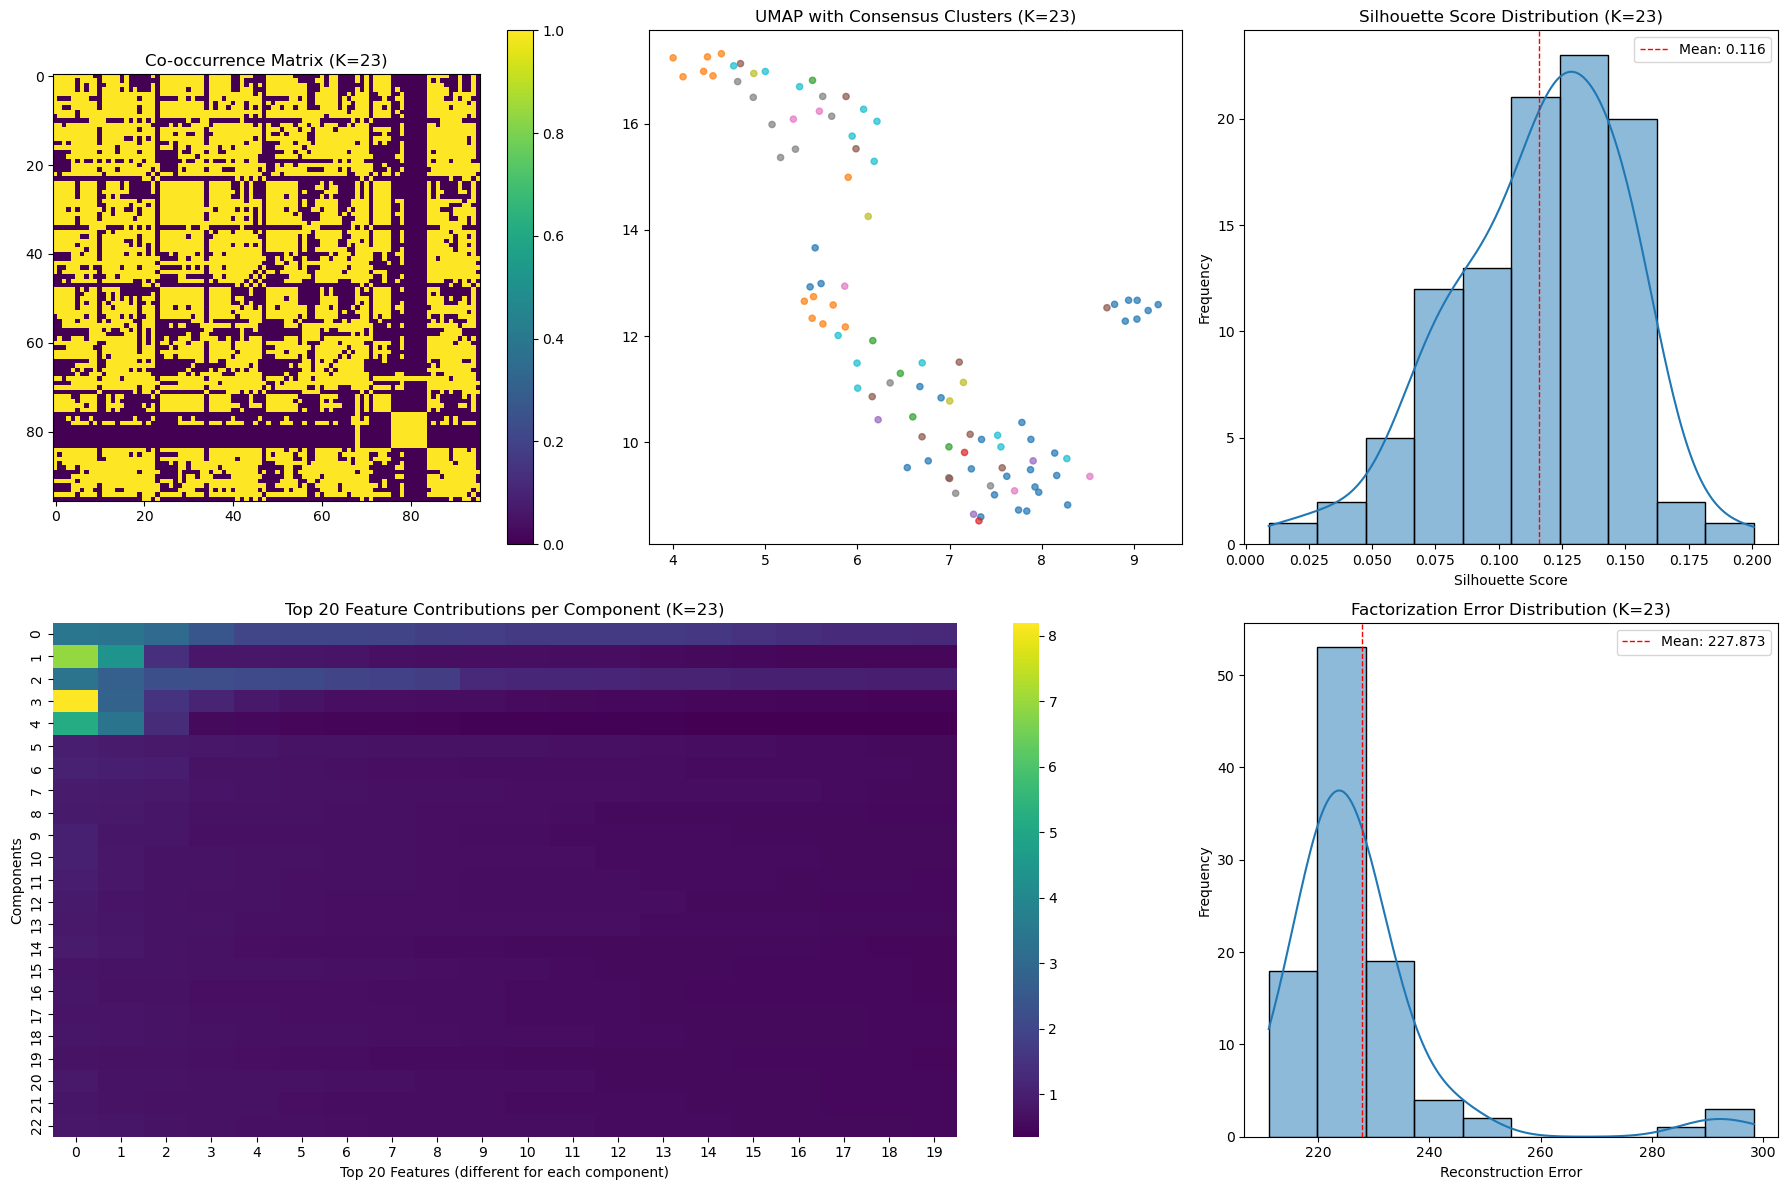

Running K=24
GMM normalization: Cutoff value = 1668.21
GMM normalization: 36 samples scaled down out of 96 total
GMM normalization: Cutoff value = 1711.80
GMM normalization: 35 samples scaled down out of 96 total
GMM normalization: Cutoff value = 989.00
GMM normalization: 55 samples scaled down out of 96 total
GMM normalization: Cutoff value = 989.73
GMM normalization: 53 samples scaled down out of 96 total
GMM normalization: Cutoff value = 893.07
GMM normalization: 59 samples scaled down out of 96 total
GMM normalization: Cutoff value = 896.79
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 914.23
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 906.86
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 918.83
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 924.88
GMM normalization: 57 samples scaled down out of 96 t

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


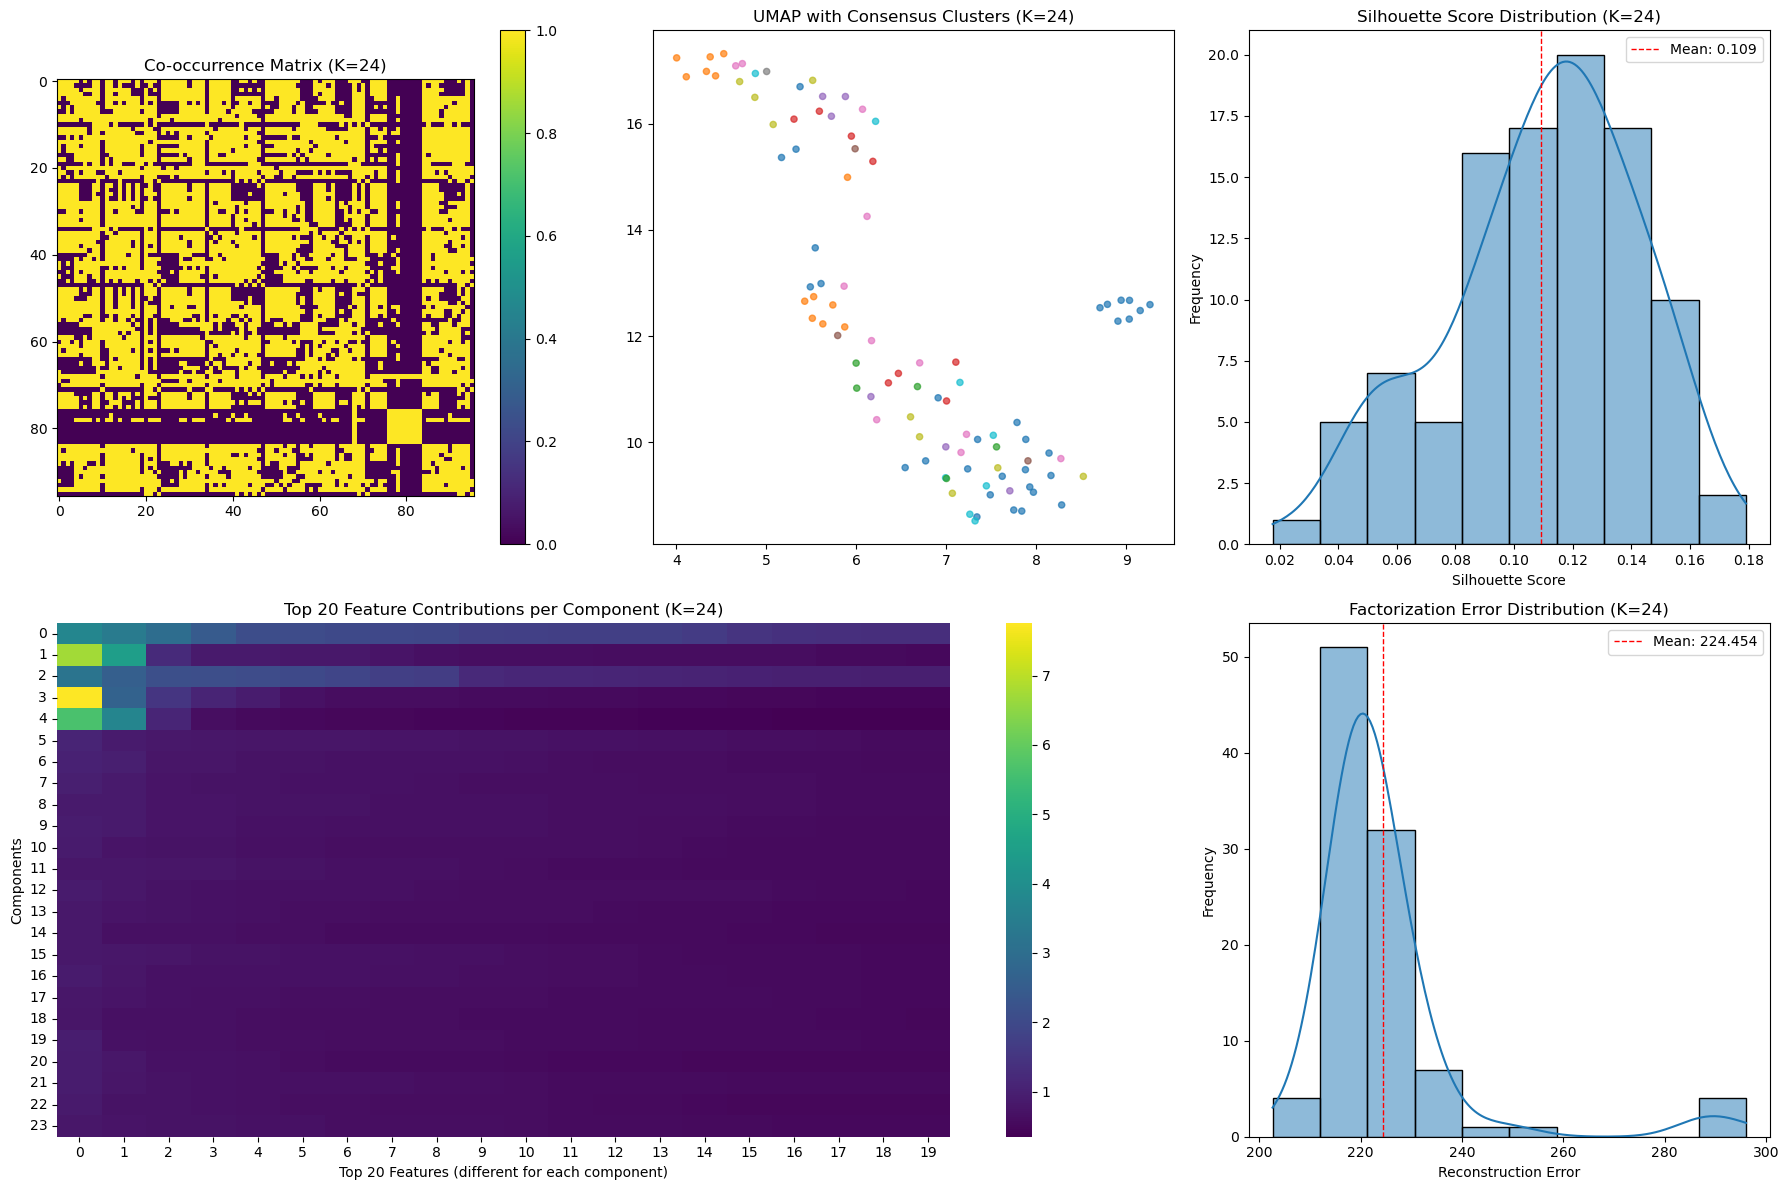

Running K=25
GMM normalization: Cutoff value = 948.50
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 942.80
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 926.11
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 996.40
GMM normalization: 53 samples scaled down out of 96 total
GMM normalization: Cutoff value = 964.49
GMM normalization: 54 samples scaled down out of 96 total
GMM normalization: Cutoff value = 947.85
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 904.09
GMM normalization: 57 samples scaled down out of 96 total
GMM normalization: Cutoff value = 942.90
GMM normalization: 56 samples scaled down out of 96 total
GMM normalization: Cutoff value = 911.86
GMM normalization: 58 samples scaled down out of 96 total
GMM normalization: Cutoff value = 921.88
GMM normalization: 58 samples scaled down out of 96 tot

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


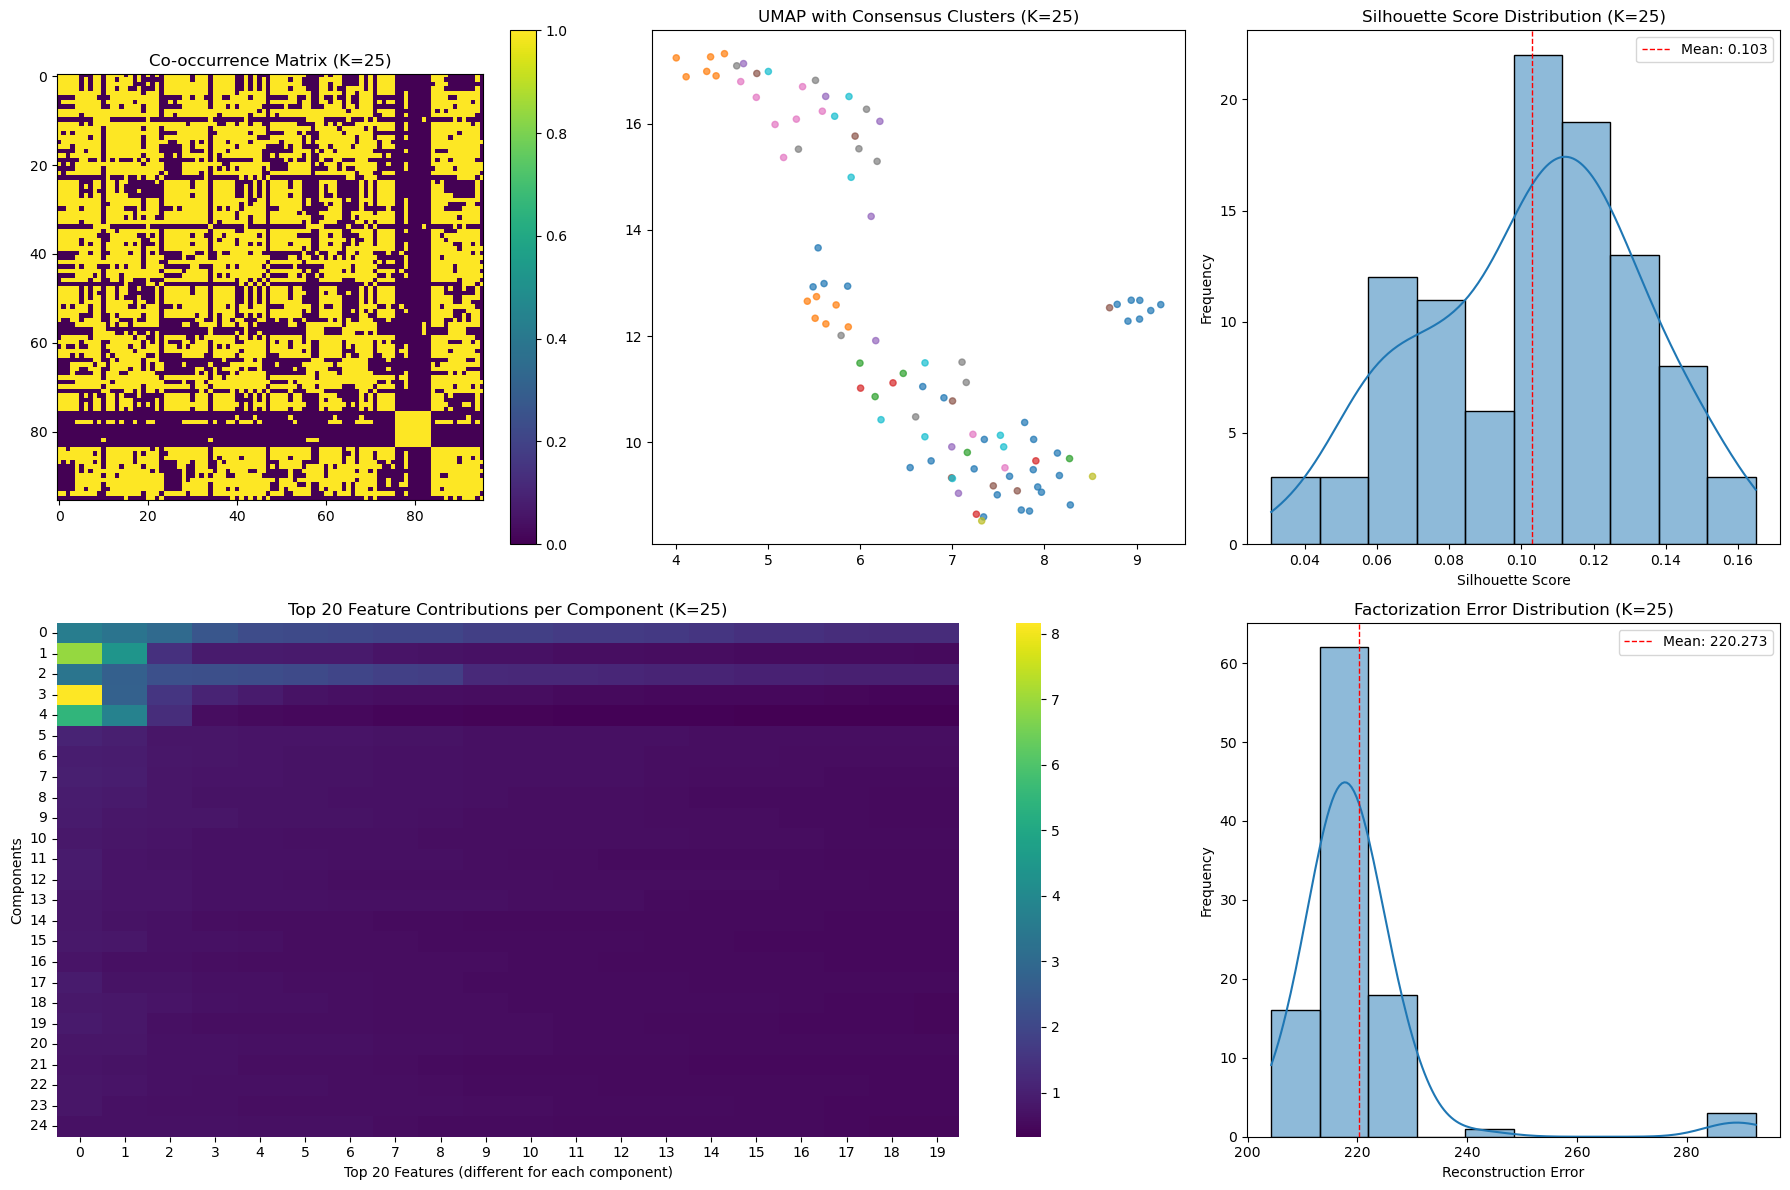

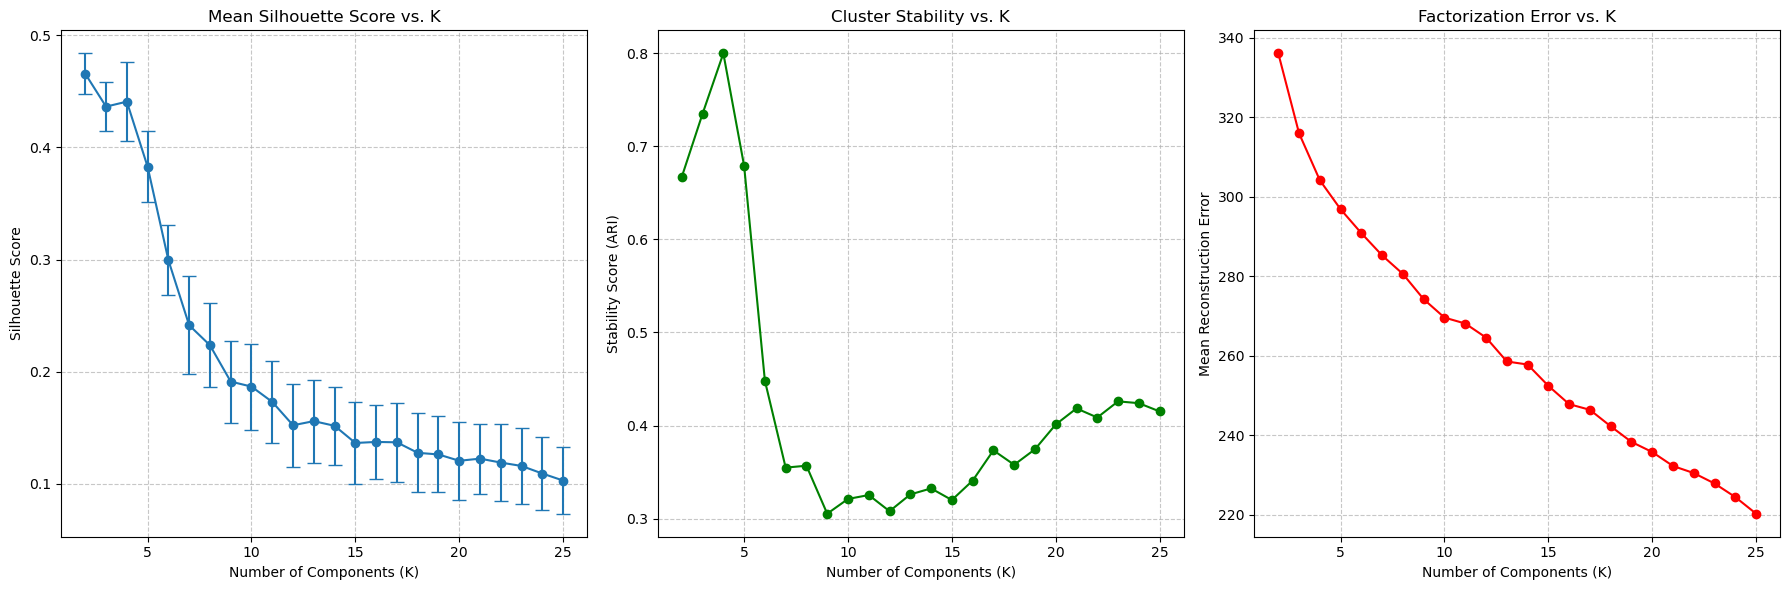

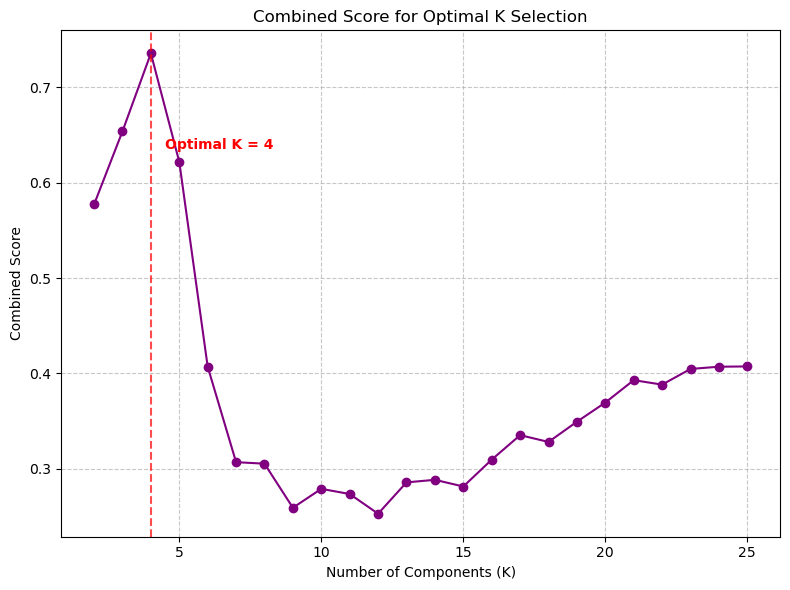

Recommended optimal number of components (K): 4
- Silhouette score: 0.4408
- Stability score: 0.8000
- Factorization error: 304.1491


In [47]:
stability_results = analyze_nmf_stability(V_raw, K_list=range(1, 26), n_bootstraps=100, normalization_method="gmm")

In [48]:
# Run NMF at optimal K (K=4)
V_resample = poisson_resample(V_raw)
V_resample_norm = normalize_data(V_resample, method="gmm")
optim_model = NMF(n_components=4, 
                init=optim_hyperparams['init'], 
                solver=optim_hyperparams['solver'],
                beta_loss=optim_hyperparams['beta_loss'], 
                max_iter=optim_hyperparams['max_iter'],
                random_state=42
                )
W_optim = optim_model.fit_transform(V_raw)
H_optim = optim_model.components_

# Store optimized W basis
W_optim_df = pd.DataFrame(W_optim, index=V_df.index)
W_optim_df.to_csv("W_optim_k_4.tsv", sep="\t")

GMM normalization: Cutoff value = 874.58
GMM normalization: 60 samples scaled down out of 96 total
